
# Topic Assignment: Feature Extraction from Time Series Data

**Note:** This notebook file for the assignment has deviations from the course guide with respect to the structure, sentence framing, question framing and numbering. Please consider this notebook file structure as the final structure and follow this.


For markdown cheat sheet see: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet - This is just for your additional reference to help you with typing and presenting your answers in the cells in notebook files and is not a part of the assignment.

Student Name: Panteleimon Manouselis
Reg No:  3084493
Group No:   11

## Instructions
We will use this jupyter note book to complete TS assignment. Please provide answer at the designated place only. After the assignment is completed convert the Notebook to PDF and submit it on Canvas. While creating PDF make sure that output is clearly visible. 
Submit also this complete notebook. This means you are required to submit two files:
1. Jupytor Notebook
2. PDF file

## UCI HAR activity recognition data set
This dataset will be used for **Exercise 4.1-4.8**.

For classifying time series data, we will work with an activity recognition
data from inertial sensors (e.g., accelerometer and gyroscope). It
has both raw data and derived features from the raw data. You can find more information about this dataset in this link - https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

You can also download data from Canvas.

The basic description about the dataset and the files are given in the *UCI HAR Dataset -->
README.txt*

## Understanding the Dataset
Read instructions from the Topic Guide.
### Pre-Processing and Windowing
The creation of features from raw data requires various pre-processing
techniques. An excerpt from the README of the UCI HAR dataset:

>The sensor signals (accelerometer and
gyroscope) were recorded with a sampling rate of 50 Hz and
pre-processed by applying noise filters and then sampled in fixed-width
sliding windows of 2.56 sec and 50\% overlap (128 readings/window).

We will first understand the windowing mentioned here. The time series data is
non-stationary, which means that the statistical properties of the signal
change over time. However, when you derive features, you want to do so from
a part of the signal that is stationary. So instead of computing features
over the whole signal which is non-stationary, you take very small windows
(or blocks) of a signal (in the order of tens of milliseconds) in which you
assume that the signal in this window is stationary.

Both the raw data (found in the folders *train/Inertial Signals* and *test/Inertial Signals*) and derived feature data (found in *train/X_train.txt and test/X_test.txt*) of this dataset consists of these windows. The length of each window of this dataset is 2.56 seconds. The overlap is 50% (observe that for any file in folders *Inertial Signals* *first 50\%* of the values in *row 2* are the same as the *last 50% values in row 1*).


In [1]:
# packages needed [you might need more]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import seaborn as sns
import statistics
import sys, time
import collections
import itertools
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.stats import mode
from scipy.stats import kurtosis
from scipy.spatial.distance import squareform
from scipy.signal import butter, filtfilt, lfilter
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tslearn.metrics import dtw
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

#### Exercise 4.1
Now, it is your turn to get to know the dataset better. For exercises 4.1-4.3 you can use the dataset with the derived features, located
in *train/X\_train.txt* and *test/X\_test.txt*.

Refer to the tutorial in [1] for some useful built-in methods from the Python library Pandas.

[1] A beginners introduction to the Python [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) package.


**Tips :**
1. **Reading Files:** read_fwf. Note that the data is separated by a space and not by a comma or tab. Therefore
you might need the optional argument delim whitespace=True. Moreover, the file does not have
any headers.
2. **Data Frame Dimension:** [shape](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.shape.html) function from Pandas.
3. **Sub-setting data frame:** It can be done in various ways. Since the data is in the form of rows and columns so easiest is to use [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html).
4. **Basic Statistics:** You can use function such as [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html), [median](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.median.html), [max](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html), [min](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html), [std](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html) Alternatively, you can use [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)



**a)** Describe the dataset (train and test set) in terms of dimensionality, how many columns and rows are there? What do the rows and columns represent?  
> Your Answer (Double click to edit): The train dataset has 7352 rows and 561 columns. Each row contains 561 features. The measurements made contained data with the 3-axial linear acceleration and the 3-axial angular velocity sampled at a constant rate of 50Hz. These measured data was then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap, thus creating 10299 windows. For EACH of the 10299 windows a vector of 561 features was obtained. 70% of those 10299 vectors were then used as the train dataset and 30% were used for the test dataset. The rows represent individual winows whereas the columns represent the different features that describe each window.

In [2]:
# Get the names of the features
feature_names = pd.read_fwf('C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/features.txt', header=None, delim_whitespace=True)

# Read the training data
X_train = pd.read_fwf('C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
# Assign correct names to the features
X_train.columns = feature_names

# Read the test data
X_test = pd.read_fwf('C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
X_test.columns = feature_names

**b)** Give summary statistics for some features of your choice (at least 5). Examples of statistics are means, standard deviations and upper and lower percentiles.

**Tip:** You can find the features name in the *UCI HAR Dataset --> features.txt*. For more understading, you can try to have these features name as headers for your dataframe.

In [3]:
# Select the columns to get summary statistics for
selected_columns = X_train.iloc[:, [0, 3, 9, 12, 16]]

# Get summary statistics for the selected columns (features selected are mean in X, std in X, max in X, min in X and energy in X)
summary_statistics = selected_columns.describe()
print(summary_statistics)

       (1 tBodyAcc-mean()-X,)  (4 tBodyAcc-std()-X,)  (10 tBodyAcc-max()-X,)  \
count             7352.000000            7352.000000             7352.000000   
mean                 0.274488              -0.605438               -0.468604   
std                  0.070261               0.448734                0.544547   
min                 -1.000000              -1.000000               -1.000000   
25%                  0.262975              -0.992754               -0.936219   
50%                  0.277193              -0.946196               -0.881637   
75%                  0.288461              -0.242813               -0.017129   
max                  1.000000               1.000000                1.000000   

       (13 tBodyAcc-min()-X,)  (17 tBodyAcc-energy()-X,)  
count             7352.000000                7352.000000  
mean                 0.550244                  -0.820041  
std                  0.321766                   0.259607  
min                  0.000212              

**End of Exercise 4.1**

We now consider the ground truth class labels. These are located in *train/y_train.txt* and
*test/y_test.txt* respectively.

#### Exercis 4.2
**Tips**
For creating Bar plots there are at least two ways in Pandas:
+ **Bar Chart:** You need to manually calculate the counts for each activity type. You can do it either by using a for loop or using a combination of [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [count](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html). Finally, create bar plot using [bar](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)
+ **Histogram:** [hist](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html) to create a Histogram.


**a)** Describe this file in terms of dimensionality, how many columns and rows are there? What do they represent (this is a very obvious question of course, don’t over-think it)?
> Your Answer (Double click to edit): As expected the train labels dataframe has a dimensionality of 7352 by 1. For each row of features in the train data we have one label in the (train) labels data frame (the ground truth). Therefore, the dimensionality is 7352 by 1. Similarly, for the test labels dataframe has a dimensionality of 2947 by 1, matching each row of features with one label (ground truth)


In [4]:
# Read the train and test labels
Y_train = pd.read_fwf('C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', header=None, delim_whitespace=True)
Y_test = pd.read_fwf('C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', header=None, delim_whitespace=True)


**b)** Plot the number of datapoints for each user activity (output class) as a bar chart with the class name displayed. Is the dataset balanced? Why is it important, for machine learning and classification purposes, that a dataset is balanced?

A dataset is considered balanced if it has roughly equal numbers of datapoints for each class. If one class has significantly more datapoints than another class, then the dataset is considered imbalanced.

It’s important for machine learning that a dataset is balanced because an imbalanced dataset can lead to biased models. If one class has significantly more datapoints than another class,then the model may be biased towards predicting that class because it has seen more examples of it during training. This can result in poor performance when making predictions on new data.

Balancing a dataset can help improve model performance by ensuring that all classes are equally represented during training.

Both the train dataset and the test dataset are slighlty unbalanced as there is some variation in the datapoints of each class.
However, the test dataset seems a bit more balanced that the train dataset



Text(0.5, 1.0, 'Class imbalance in test labels')

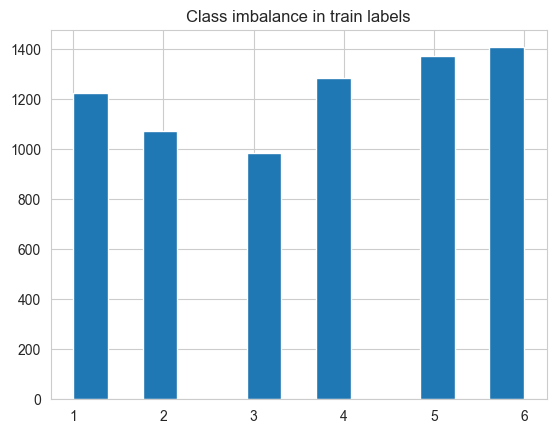

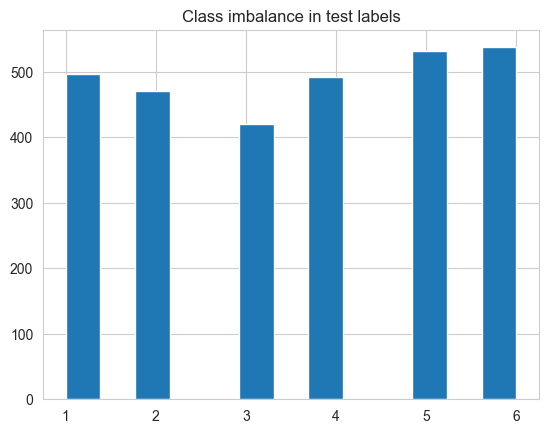

In [5]:
# Bar plot of train labels
hist_train = Y_train.hist(bins=13) # 13 bins to let space between the bins created and not overcrowd figure
plt.title('Class imbalance in train labels')

# Bar plot of test labels
hist_test = Y_test.hist(bins=13) # 13 bins to let space between the bins created and not overcrowd figure
plt.title('Class imbalance in test labels')

**End of Exercixe 4.2**

Next, we want to compare the values and shapes of the features for every class. The features may look
different for different classes (a truck has 2 doors and a car 3 or more) and this corresponds to the idea that
we want to differentiate and classify whether a signal from this database comes from walking or standing
for example.

**To be able to do the above said classification, you first need to couple the class labels (Y) with the feature data values (X). You have inspected the dimensions of both which provides a clue about how this should be done.**

In [6]:
# Rename the column name of the Label dataframes
Y_train.rename(columns={0: 'labels'}, inplace=True)
Y_test.rename(columns={0: 'labels'}, inplace=True)

# Combine X and Y for both train and test datasets
train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test], axis=1)


To create distribution you can use the following:  
+ **Features to Distribution:** The [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) package in Python allows you to easily use Kernel Density Estimates (KDE) to turn the feature values into distributions.
+

#### Exercise 4.3 
**Note:** In the guide this exercise is written as one paragraph. For convineince we have broken it into smaller subparts.  
**a)** Choose 10 features (it does not matter which
ones) and for every feature, plot the distributions of every class for that feature in one figure.
So, for a single feature you should have one plot which includes six distributions corresponding to the classes. 


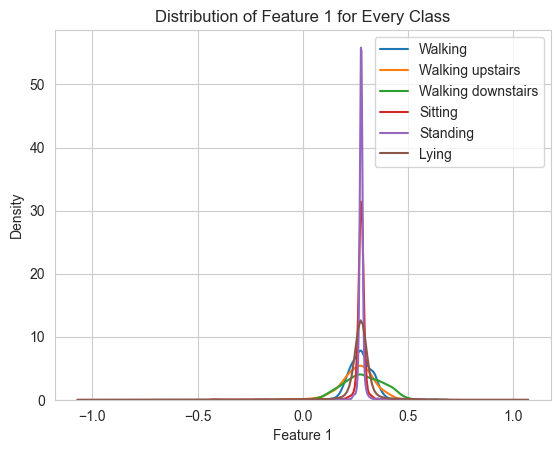

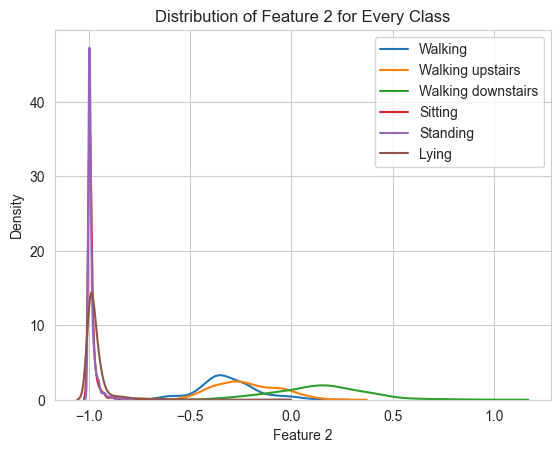

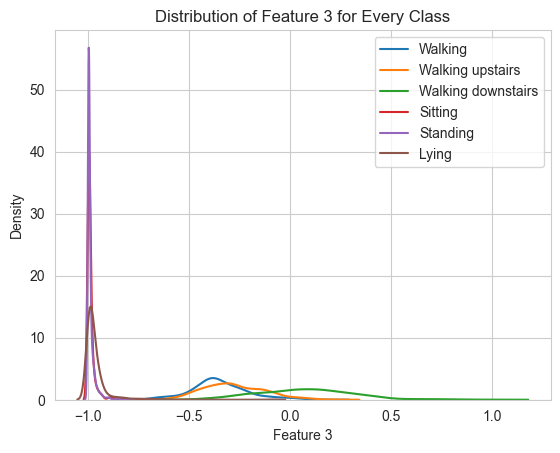

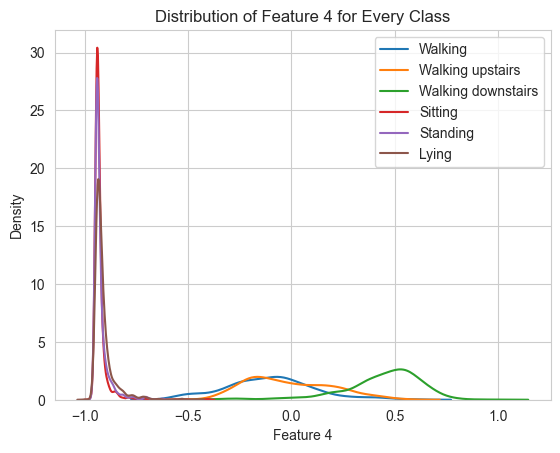

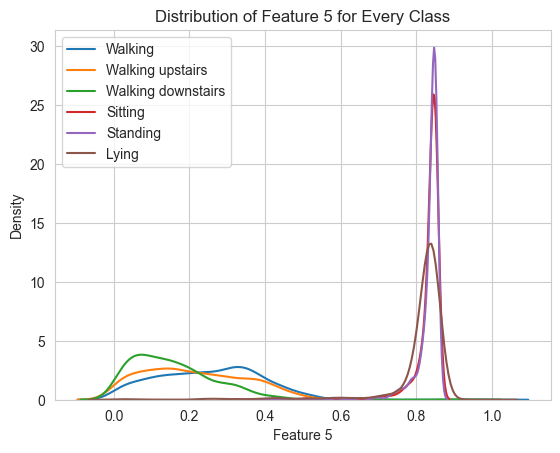

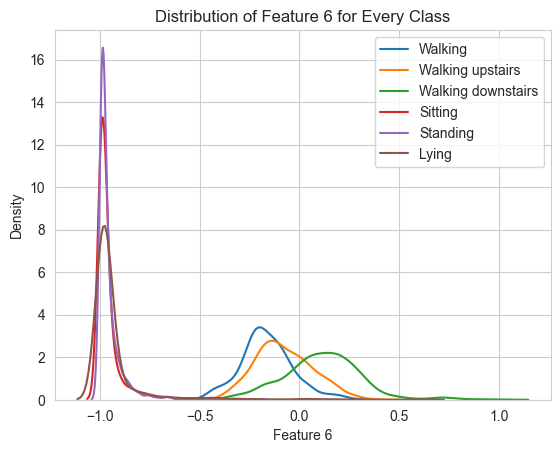

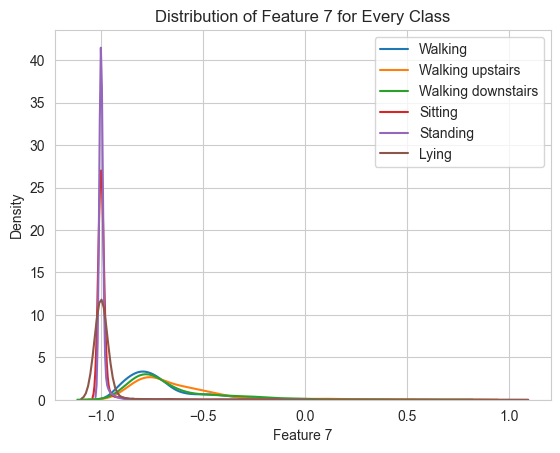

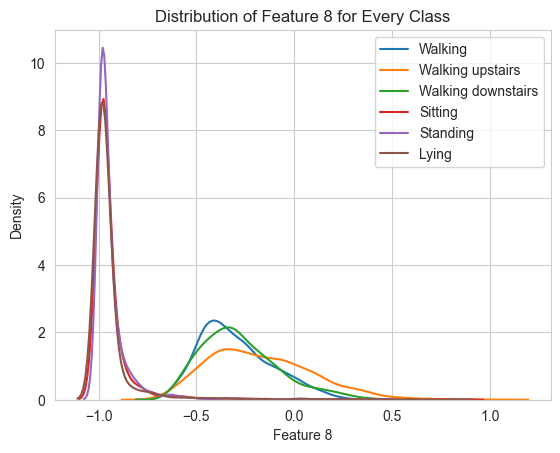

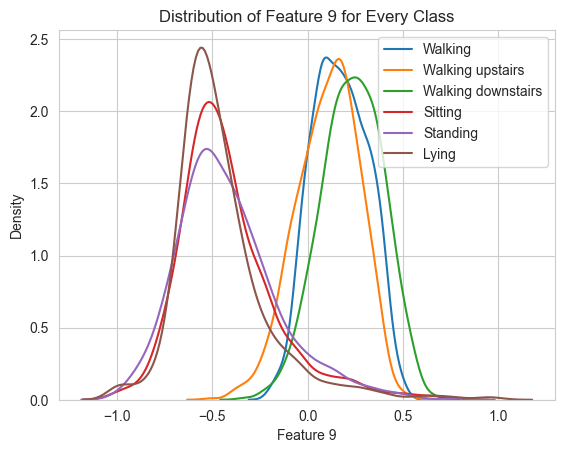

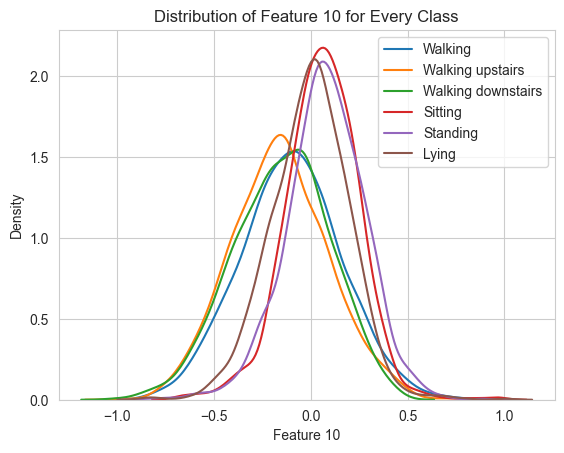

In [7]:
# Isolate the feature values for each class and select 10 features
walking_features = train_data[train_data["labels"] == 1].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values
walking_upstairs_features = train_data[train_data["labels"] == 2].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values
walking_downstairs_features = train_data[train_data["labels"] == 3].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values
sitting_features = train_data[train_data["labels"] == 4].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values
standing_features = train_data[train_data["labels"] == 5].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values
lying_features = train_data[train_data["labels"] == 6].iloc[:, [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]].values

# Plot the distributions of every class for 10 features in one figure
for i in range(10):
    fig, ax = plt.subplots()
    sns.kdeplot(walking_features[:, i], ax=ax, label='Walking')
    sns.kdeplot(walking_upstairs_features[:, i], ax=ax, label='Walking upstairs')
    sns.kdeplot(walking_downstairs_features[:, i], ax=ax, label='Walking downstairs')
    sns.kdeplot(sitting_features[:, i], ax=ax, label='Sitting')
    sns.kdeplot(standing_features[:, i], ax=ax, label='Standing')
    sns.kdeplot(lying_features[:, i], ax=ax, label='Lying')
    ax.set_xlabel('Feature ' + str(i+1))
    ax.set_ylabel('Density')
    ax.set_title('Distribution of Feature ' + str(i+1) + ' for Every Class')
    ax.legend()
    plt.show()

**b)** Visually inspect the six different distributions in the figure for every feature and
report the nature of distributions (e.g., normal distribution or not, skewness, modality, etc.). 

>your answer (double click to edit):
 > Upon inspecting the 10 plots, we can observe that all the distributions are unimodal, meaning they have only one peak.

For features 2 to 8, the walking, walking upstairs, and walking downstairs classes exhibit skewed distributions, while the remaining classes for these features appear to follow a normal distribution, albeit with some degree of skewness.

For features 1, 9, and 10, all classes appear to follow a normal distribution,
although there is some skewness present in the distributions of the walking,
walking upstairs, and walking downstairs classes for these features."




**c)** Is it possible to discriminate between activities based on those chosen features? Are there differences between the walking
activities and non-walking activities such as lying down and sitting? What explains these differences?

>your answer (double click to edit):  Based on the selected 10 features alone, discriminating between all six activities with high accuracy may be challenging. However, certain activities may be more distinguishable than others based on these features. For instance, the standing activity exhibits the highest peak in eight out of the 10 features, making it easier to differentiate from the other activities.

Additionally, while discriminating between all six activities might be challenging, we could merge the three walking activities into a single class (e.g., just walking) to facilitate discrimination. All three walking classes have distributions with distinct centers from the other activities, making it relatively easy to distinguish between samples in this super class and the rest of the activities.

Furthermore, there are differences between the walking activities and non-walking activities such as lying down and sitting. One possible explanation for these differences is the level of physical activity involved.This increased physical activity could result in differences in the measured features, such as acceleration ,between the walking and non-walking activities.

**End of Exercixe 4.3**

### Exploring the Raw Data

For this part of the assignment, we are going to focus on the raw signal
sensor data of the UCI HAR dataset. The raw data can be found in the
folders */Inertial Signals* in the *train* and *test*
folders respectively. You will find 6 files which correspond to the axes of
the accelerometer and gyroscope respectively.  
Calculate the variances of
the accelerations of all 3 axes with aid of the *total\_acc\_* files
of the 3 axes and select the corresponding body acceleration file
(*body\_acc\_*) from the axis that has the highest variance. (see also the question below)  
The raw data is somewhat different from the feature data. In the feature data,
every feature had 1 value which was calculated from each window, thus the
whole window is represented as 1 value. In the raw data, the windowing is
again used but since no features have been created from this raw data, this
data contains the individual datapoints from the windows. We first want to
reconstruct the original signal from this windowed version.


#### Exercise 4.4 
**a)** Calculate the *variances* of the accelerations of all 3 axes using the *total_acc_* files. From this, check which axis has the highest variance and select the body acceleration file (*body_acc_* ) corresponding to that axis. Make use of this *body_acc_* file for the upcoming exercises. Which *total_acc_* file has the highest variance and which *body_acc_* file have you chosen?

>your answer (double click to edit): The total_acc_x has the highest variance. We therefore choose body_acc_x_train

In [8]:
main_dir = "C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/UCI HAR Dataset/UCI HAR Dataset/"
total_acc_x_train = pd.read_fwf(main_dir + 'train/Inertial Signals/total_acc_x_train.txt', header=None, delim_whitespace=True)
total_acc_y_train = pd.read_fwf(main_dir + 'train/Inertial Signals/total_acc_y_train.txt', header=None, delim_whitespace=True)
total_acc_z_train = pd.read_fwf(main_dir + 'train/Inertial Signals/total_acc_z_train.txt', header=None, delim_whitespace=True)
body_acc_x_train = pd.read_fwf(main_dir + 'train/Inertial Signals/body_acc_x_train.txt', header=None, delim_whitespace=True)
body_acc_y_train = pd.read_fwf(main_dir + 'train/Inertial Signals/body_acc_y_train.txt', header=None, delim_whitespace=True)
body_acc_z_train = pd.read_fwf(main_dir + 'train/Inertial Signals/body_acc_z_train.txt', header=None, delim_whitespace=True)

# Recover original signals
window_size = total_acc_x_train.shape[1]
total_acc_x_train_melted = total_acc_x_train.iloc[:, 0:(window_size//2)]
total_acc_x_train_melted = total_acc_x_train_melted.stack().reset_index(drop=True)

total_acc_y_train_melted = total_acc_y_train.iloc[:, 0:(window_size//2)]
total_acc_y_train_melted = total_acc_y_train_melted.stack().reset_index(drop=True)

total_acc_z_train_melted = total_acc_z_train.iloc[:, 0:(window_size//2)]
total_acc_z_train_melted = total_acc_z_train_melted.stack().reset_index(drop=True)

# Calculate the variances of the total acceleration signals for each axis
total_acc_variances = [np.var(total_acc_x_train_melted), np.var(total_acc_y_train_melted), np.var(total_acc_z_train_melted)]
# Find the axis with highest variance

max_var_axis = np.argmax(total_acc_variances)
print(total_acc_variances)
print("Axis with highest variance is "+ str(max_var_axis))


[0.17128219177695397, 0.1528618082041395, 0.12779244853103627]
Axis with highest variance is 0


**b)** Describe this axis file in terms of dimensionality, how many columns and rows are there? What do
they represent in this case? Hint: Use the information about the sample rate and window size provided at the start of this assignment to
determine the answers.

>your answer (double click to edit): The body_acc file has the same number of rows as the total_acc file, which is 7352. The number of columns is equal to the window size. The number of rows depends on the number of samples in the original signal, the window size and the overlap. In our case we originally had 470592 samples. If we select a window size of 2.56 seconds and since the sampling rate was 50Hz we will have 2.56*50 = 128 samples per window. With 50% overlap per window and having originally 470592 samples, one would then create 470592/(128*0.5) = 7352 windows.



The raw data is somewhat different from the feature data. In the feature data, every feature had 1 value which was calculated from each window, thus the whole window is represented as 1 value. In the raw data, the windowing is again used but since no features have been created from this raw data, this data contains the individual datapoints from the windows. We first want to reconstruct the original signal from this windowed version. 

**c)-1** 
**Note: part c is divided further for ease of answering**
Reconstruct the original signal from the raw data. As mentioned at the start of this assignment, the data has 50% overlap(first 50% of the values in row 2 are the same as the last 50% values in row 1). Once you have successfully dealt with the window overlap, you can concatenate the datapoints to reconstruct the original signal. 

Hint: To concatenate columns above each other, you can use [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function. The example code given below the image will give you an idea of how to use the melt function.

NB: The expected output for the reconstructed signal for *body_acc_x_train.txt* should look like as follows:
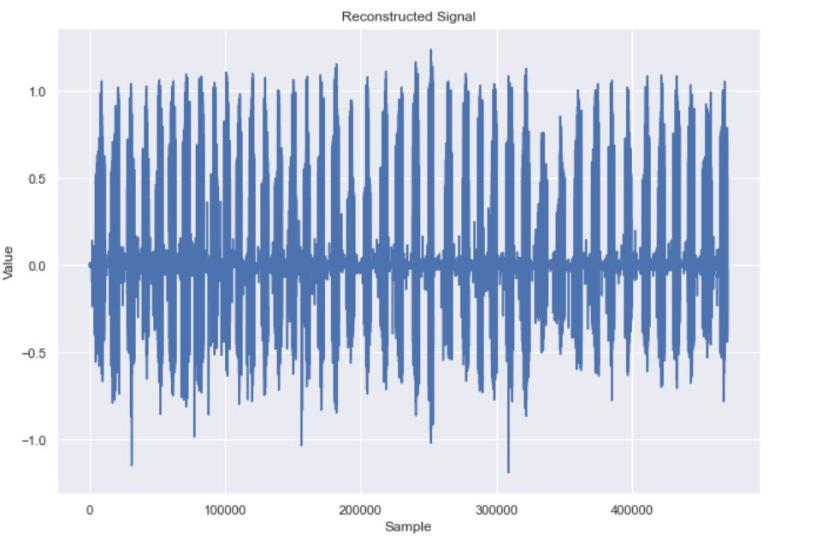

In [9]:
# Example code to understand melt function


a = np.arange(1,28).reshape(9,3)
test = pd.DataFrame({'c1': a[:, 0], 'c2': a[:, 1], 'c3': a[:, 2]})
c4 = ['1', '0', '1', '0', '1', '0', '1', '0', '1']
test['c4'] = c4
print('\nTest dataframe')
print(test)
# We ignore the fourth column since it has labels only
test_slice = test.iloc[:,:3]
test_melt = test_slice.transpose()
test_melt = test_melt.melt()
print('\nAfter using the melt function on the data frame')
print(test_melt['value'])
# Note that you still have to catenate label again


Test dataframe
   c1  c2  c3 c4
0   1   2   3  1
1   4   5   6  0
2   7   8   9  1
3  10  11  12  0
4  13  14  15  1
5  16  17  18  0
6  19  20  21  1
7  22  23  24  0
8  25  26  27  1

After using the melt function on the data frame
0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
Name: value, dtype: int32


In [10]:
overlap = 0.5
# Create an array to store the original signal and its corresponding labels

signal_and_labels = np.zeros((len(total_acc_x_train_melted)+window_size//2, 2))

# Iterate over each window in the body_acc_x_train dataframe
for i in range(body_acc_x_train.shape[0]):
    # Calculate the start and end indices of the current window in the original signal
    start_idx = int(i * window_size * (1 - overlap))
    end_idx = start_idx + window_size

    # Assign the label of the current window to each sample in the window
    label = Y_train.iloc[i].values[0]
    signal_and_labels[start_idx:end_idx, 1] = label

    # Assign the values of the current window to the corresponding samples in the original signal
    signal_and_labels[start_idx:end_idx, 0] = body_acc_x_train.iloc[i].values


**c)-2** In the previous question what is the consequence of the overlap and how did you deal with this?
>your answer : The consequence of the overlap is that if we just try to straighten the dataframe we will end up with a lot of duplicate data (proportional number of duplicate data to the overlap of the windows). As a consequence we will have a dataframe which is way larger than the original one and not as usefull (due to the duplicate data). To deal with this we effectivelly drop the last 50% of the values of each row (since overlap is 50%)

**c)-3** Now with the above concatenated signal, couple the class labels Y. Before you do this, make sure you have the length of the class labels the same as that of the concatenated signal.

In [11]:
print("Code written in c) 1)")

Code written in c) 1)


**End of Exercise 4.4**

### The Time Domain and the Frequency Domain

Features can be constructed from the signal in the time domain or from the frequency domain. First we will
start to look at the signal in the frequency domain.

**Reading Materials:**
1. Time domain features
(a) http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats
(b) https://docs.scipy.org/doc/scipy-0.7.x/reference/stats.html

#### Exercise 4.5
**a)** Use your raw signal to recreate some time domain features such as [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html), [standard deviation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html), [kurtosis](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurtosis.html) or features of your own choosing; some examples can be found in the article by Altin et al. [2]

[2] C. Altın and O. Er, “Comparison of different time and frequency domain feature extraction methods
on elbow gesture’s emg,” European Journal of Interdisciplinary Studies, vol. 5, no. 1, pp. 35–44,
2016. You can acces this article via this link: http://journals.euser.org/files/articles/ejis_may_aug_16/Cemil.pdf 
Please copy the link, clicking may not work.



In [12]:
# Extract the signal data from signal_and_labels array
signal = signal_and_labels[:, 0]

# Compute time domain features
mean = np.mean(signal)
std = np.std(signal)
kurto = kurtosis(signal)

peak_to_peak = np.max(signal) - np.min(signal)
skewness = np.mean(np.power(signal - mean, 3)) / np.power(std, 3)

# Print the computed features
print("Mean: ", mean)
print("Standard deviation: ", std)
print("Kurtosis: ", kurto)
print("Peak-to-peak amplitude: ", peak_to_peak)
print("Skewness: ", skewness)

Mean:  -0.0011436954268365211
Standard deviation:  0.19513416959496313
Kurtosis:  4.61814549232457
Peak-to-peak amplitude:  2.427656
Skewness:  1.0060079122934382


**b)** Report whether some of the time domain features have the potential to discriminate between multiple activities. For example, you could combine the means and standard deviations of the classes to reconstruct a normal distribution of the classes and visually inspect whether discrimination between activities is possible. 
> your answer : By compining the means and standard deviations of the classes to reconstruct the normal distributions of the classes, one can see that the distributions between the three walking classes are almost intistiguishable. On the contrary, the distributions of sitting, standing and lying are different from the walking ones (higher kurtosis) and those classes may be somewhat distinguishable (although their distributions seem relatively similar and the difference is the peak)

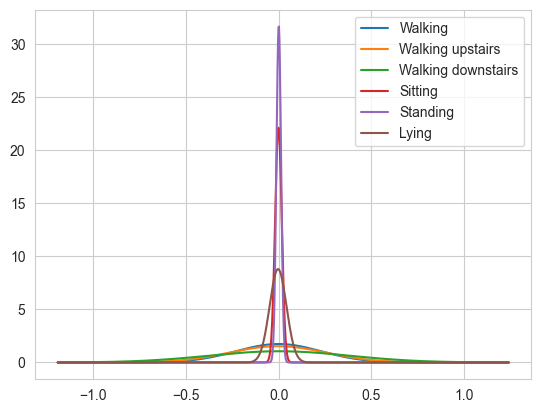

In [13]:
# Extract the signal data and labels from signal_and_labels array
signal = signal_and_labels[:, 0]
labels = signal_and_labels[:, 1]

# Compute the mean and standard deviation of the signal for each activity
walking_mean = np.mean(signal[labels == 1])
walking_std = np.std(signal[labels == 1])

walking_upstairs_mean = np.mean(signal[labels == 2])
walking_upstairs_std = np.std(signal[labels == 2])

walking_downstairs_mean = np.mean(signal[labels == 3])
walking_downstairs_std = np.std(signal[labels == 3])

sitting_mean = np.mean(signal[labels == 4])
sitting_std = np.std(signal[labels == 4])

standing_mean = np.mean(signal[labels == 5])
standing_std = np.std(signal[labels == 5])

lying_mean = np.mean(signal[labels == 6])
lying_std = np.std(signal[labels == 6])

x = np.linspace(np.min(signal), np.max(signal), 1000)
walking_dist = np.exp(-0.5 * ((x - walking_mean) / walking_std) ** 2) / np.sqrt(2 * np.pi * walking_std ** 2)

walking_upstairs_dist = np.exp(-0.5 * ((x - walking_upstairs_mean) / walking_upstairs_std) ** 2) / np.sqrt(2 * np.pi * walking_upstairs_std ** 2)

walking_downstairs_dist = np.exp(-0.5 * ((x - walking_downstairs_mean) / walking_downstairs_std) ** 2) / np.sqrt(2 * np.pi * walking_downstairs_std ** 2)

sitting_dist = np.exp(-0.5 * ((x - sitting_mean) / sitting_std) ** 2) / np.sqrt(2 * np.pi * sitting_std ** 2)

standing_dist = np.exp(-0.5 * ((x - standing_mean) / standing_std) ** 2) / np.sqrt(2 * np.pi * standing_std ** 2)

lying_dist = np.exp(-0.5 * ((x - lying_mean) / lying_std) ** 2) / np.sqrt(2 * np.pi * lying_std ** 2)

plt.plot(x, walking_dist, label='Walking')
plt.plot(x, walking_upstairs_dist, label='Walking upstairs')
plt.plot(x, walking_downstairs_dist, label='Walking downstairs')
plt.plot(x, sitting_dist, label='Sitting')
plt.plot(x, standing_dist, label='Standing')
plt.plot(x, lying_dist, label='Lying')
plt.legend()
plt.show()

**End of Exercise 4.5**

In some cases, looking at a signal in the time domain is not informative. Looking at your raw signal, you
will see a significant amount of noise and at first glance, any pattern is difficult to discover. Another way of
looking at the signal is in terms of the frequencies it consists of. Decomposing the signal into frequencies
and magnitudes of those frequencies can show useful patterns (dominating frequencies) in the frequency
domain. One technique to translate a signal towards the frequency domain is the Fourier transform. You
can read the excerpt of Jurafsky and Martin (section 9.3.3) [3] [link to paper]( https://www-dawsonera-com.ezproxy2.utwente.nl/readonline/9781292037936) for a quick refresh. You can watch the video
by Wiliam Cox in reference [4] if you need more background on this subject. In addition, Kulkarni [5]
provides the more theoretical background. The section in Jurafsky and Martin covers why we want to use
windowing as well as the notion that we will use a special case of the Fourier transform; the Discrete Fourier
Transform (DFT) for discrete sampled data.

An effective algorithm to compute the DFT is called the Fast Fourier Transform (FFT). Python’s *scipy*
module comes with the option to calculate the FFT of a signal with the [fft](https://docs.scipy.org/doc/scipy/tutorial/fft.html) method. This method returns the Fourier coefficients which contain a real and an imaginary part since the transfrom is based on Eulers formula. The real and imaginary part correspond to the magnitude and phase of the frequency components present in the signal. To correctly plot a spectrum, some more steps are required and these are explained in [6]. This reference also covers how the symmetry of the transform can be handled to correctly plot the resulting spectrum. Alternatively, some more information and a more practical approach to programming the FFT is given in the Python project by Punbat [7].

**Additional References for your perusal**
[3]Section 9.3.3 about Windowing in Jurafsky and Martin. You can access the book via the link below
by logging in with your student account. https://www-dawsonera-com.ezproxy2.utwente.nl/readonline/9781292037936 Please copy the link, clicking may not work.
[4] William Cox provides an introduction to the Fourier transform and its implementation, the Fast Fourier
Transform in his talk at the PyData Seattle conference in 2015. https://www.youtube.com/watch?v=YEwIjyOKFQ4 Please copy the link, clicking may not work.
[5] Chapter on Fourier Transforms by Sanjeev R. Kulkarni. The chapter can be viewed by the following link and then clicking on the document named ”frequency.pdf”: https://www.princeton.edu/˜cuff/ele201/kulkarni_text/ Please copy the link, clicking may not work.
[6] The first section, titled ”One dimensional discrete Fourier transforms” covers the implementation of
Python’s fft method and how to correctly plot the resulting spectrogram https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html Please copy the link, clicking may not work.
[7] Nipun Batra gives a more practical approach to the FFT in this Python example. https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/ft.ipynb Please copy
the link, clicking may not work.

#### Exercise 4.6 
Read the [scipy](https://docs.scipy.org/doc/scipy/tutorial/fft.html) documentation to complete the following questions.

Implement the Fourier transform to plot the spectra of all 6 activities. Keep in mind the length of
the sample you want to transform to the frequency domain and the sample rate (referred to as sample
spacing in the scipy documentation). It could be that a large peak is visible in the spectrum at 0Hz. A
frequency of 0 Hz denotes something that is referred to as a DC-offset. You can remove a DC-offset by
subtracting the mean of the data from the data as data=data-mean(data).


**a)** Before you apply the Fourier transform to the actual data, it is wise to create a test signal with known frequency components and amplitudes as given:

$sin(2 ∗ 2πx) +0.8sin(4 ∗ 2πx) +0.5sin(6 ∗ 2πx)$

The above test signal has components of 2 Hz, 4Hz and 6Hz with amplitude 1.0 , 0.8 and 0.5 respectively. To this signal, implement the Fourier transform. You can make use of the fft and fftfreq methods present in the python scipy module. Below are the plots of the test signal and its spectrum that you will see after implementation.


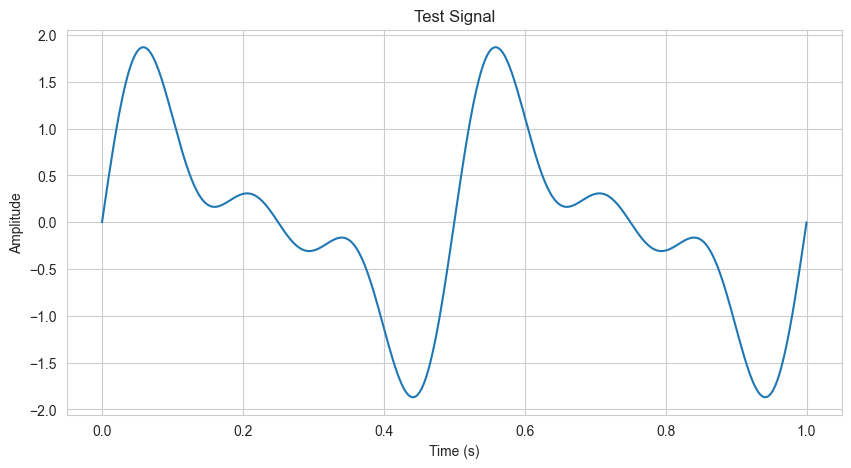

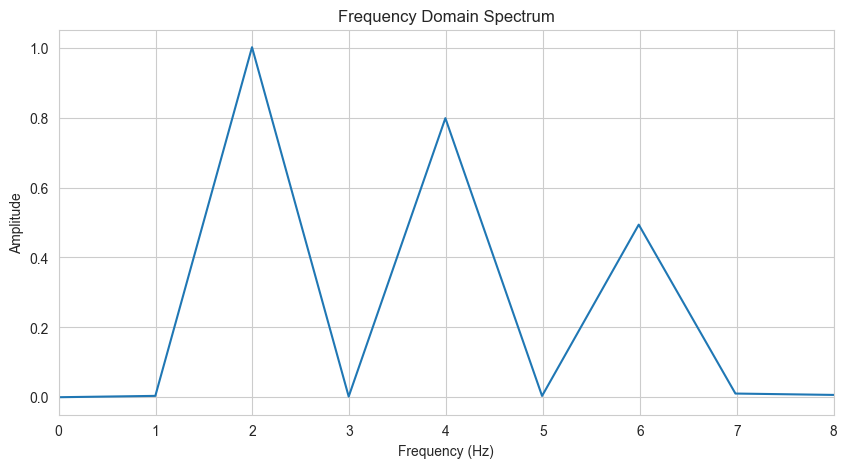

In [14]:
# Define the signal
x = np.linspace(0, 1, 500)
test_signal = np.sin(2 * 2 * np.pi * x) + 0.8 * np.sin(4 * 2 * np.pi * x) + 0.5 * np.sin(6 * 2 * np.pi * x)

# Compute Fourier transform
n = len(test_signal)
sampling_rate = 1/(x[1] - x[0]) # 500Hz
nyquist_freq = sampling_rate/2 #250 Hz
freqs = fftfreq(n, d=1/sampling_rate)
mask = (freqs >= 0) & (freqs <= nyquist_freq)
fft_vals = fft(test_signal)
fft_vals = 2.0/n * np.abs(fft_vals) # normalize the amplitude

# Plot time domain signal
plt.figure(figsize=(10, 5))
plt.plot(x, test_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Test Signal')
plt.show()

# Plot frequency domain spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs[mask], fft_vals[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectrum')
plt.xlim(0, 8)
plt.show()


**b)** Now apply the Fourier transform to your actual concatenated signal to plot the spectra of all 6 activities (one plot per activity).

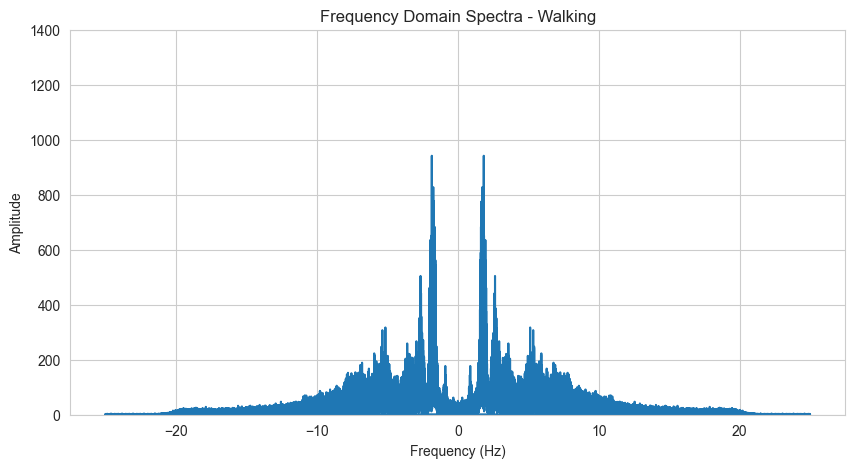

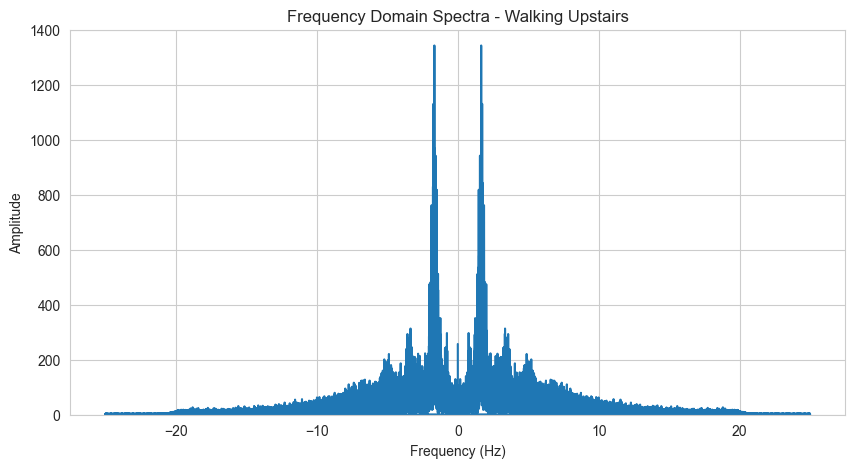

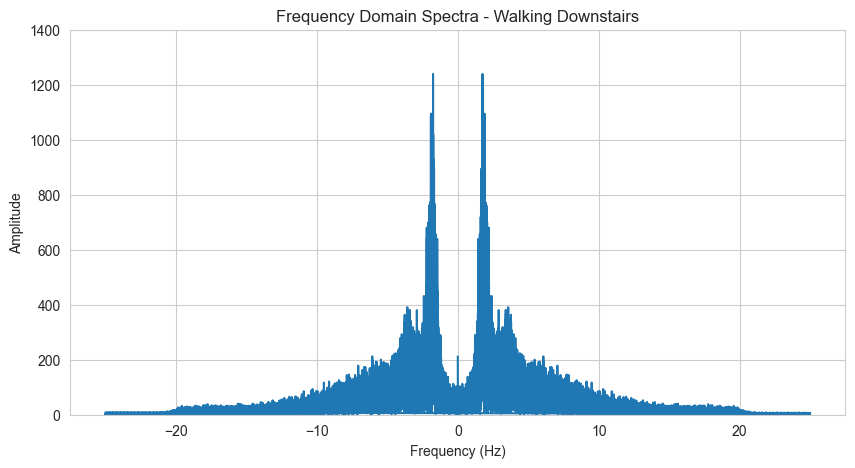

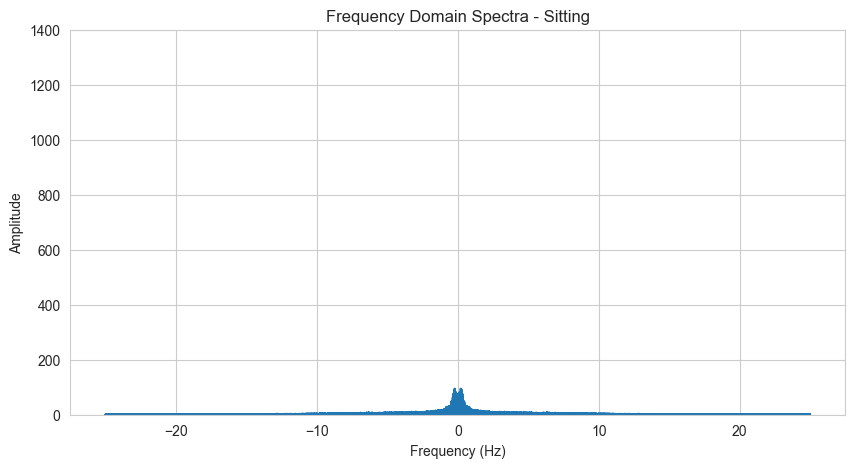

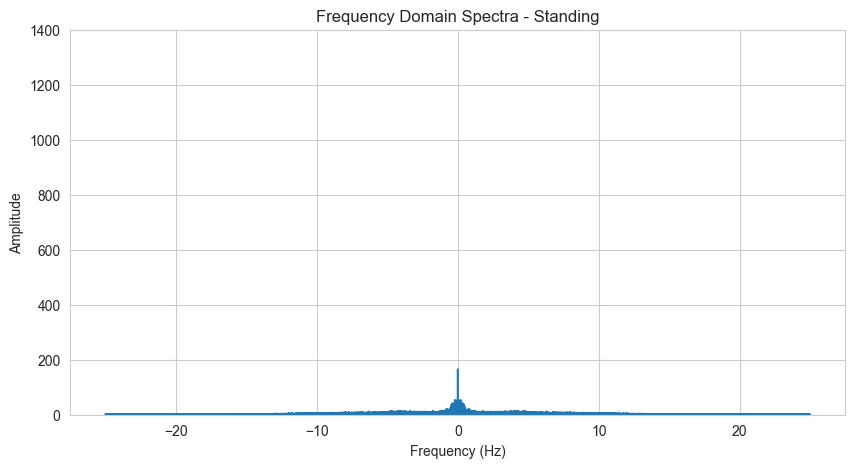

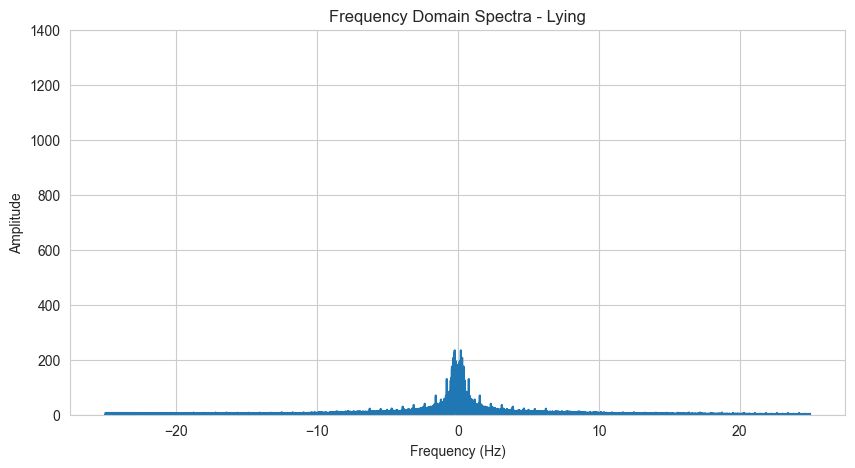

In [15]:
# Subtract the mean of the signal from the signal
signal -= np.mean(signal)

# Compute the Fourier transform for each activity
walking_fft = fft(signal[labels == 1])
walking_upstairs_fft = fft(signal[labels == 2])
walking_downstairs_fft = fft(signal[labels == 3])
sitting_fft = fft(signal[labels == 4])
standing_fft = fft(signal[labels == 5])
lying_fft = fft(signal[labels == 6])

# Compute the frequency axis for the spectra
sampling_rate = 50 # Hz

walking_freqs = fftfreq(len(walking_fft), 1 / sampling_rate)
walking_upstairs_freqs = fftfreq(len(walking_upstairs_fft), 1 / sampling_rate)
walking_downstairs_freqs = fftfreq(len(walking_downstairs_fft), 1 / sampling_rate)
sitting_freqs = fftfreq(len(sitting_fft), 1 / sampling_rate)
standing_freqs = fftfreq(len(standing_fft), 1 / sampling_rate)
lying_freqs = fftfreq(len(lying_fft), 1 / sampling_rate)

# Plot the spectra of all 6 activities
plt.figure(figsize=(10, 5))
plt.plot(walking_freqs, np.abs(walking_fft), label='Walking')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Walking')
plt.ylim(0, 1400)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(walking_upstairs_freqs, np.abs(walking_upstairs_fft), label='Walking upstairs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Walking Upstairs')
plt.ylim(0, 1400)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(walking_downstairs_freqs, np.abs(walking_downstairs_fft), label='Walking downstairs')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Walking Downstairs')
plt.ylim(0, 1400)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sitting_freqs, np.abs(sitting_fft), label='Sitting')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Sitting')
plt.ylim(0, 1400)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(standing_freqs, np.abs(standing_fft), label='Standing')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Standing')
plt.ylim(0, 1400)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(lying_freqs, np.abs(lying_fft), label='Lying')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Spectra - Lying')
plt.ylim(0, 1400)
plt.show()

**c)** After plotting the spectra for all 6 activities, determine whether it is possible to discriminate between activities based on the spectra. 

>your answer : Based on the plotted spectra, it is possible to discriminate between some activities, but not all. For example, the frequency spectrum of  the three walking activies has very high amplitudes compared to the other three activities. Furthermore, the spectra of lying is somewhat unique as it has low amplitudes but is somewhat wider (flatter). Therefore, we can distinguish that class. However, the spectra of standing and sitting appear to be relatively similar, which could make it difficult to distinguish between these two activities based on the frequency domain alone.

**End of Exercise 4.6**

### Filtering

Accelerometer data is fairly noisy. Especially the high frequency components interfere with the signals of our interest (i.e., those corresponding to user steps). Filtering can remove certain frequencies (certain partsof the spectra we created in the previous exercise) and is often a necessity. To those unfamiliar with filters, the resource is useful -> Explanation on audio filtering presented by Wick van den Belt for WickieMedia audio tutorials https://www.youtube.com/watch?v=rkwS6vigSyE Please copy the link, clicking may not work.

#### Exercise 4.7

**a)** Which frequencies (high or low) do you expect to be present in the 6 activities of this dataset? Use the answer of this question to determine sensible cutoff frequencies for your filters in the next question.
> your answer : During walking, the acceleration signals would be expected to have frequencies in the range of 0.5-5 Hz for each step, as well as higher frequency components due to body movements and vibrations.During standing and sitting, there would be little or no low-frequency components due to step activity, but there might be higher frequency components due to small body movements. Although through the figures in exercise 4.6 one notices that lying down has higher frequency components that standing and sitting we generally expect the lying down accelerometer data to have the lowest frequency components and the least amount of high-frequency components since the body is relatively still.

Based on the above, sensible cutoff frequencies for filtering would depend on the activity being analyzed. For example, a high-pass filter with a cutoff frequency of 0.5 Hz may be appropriate for filtering out low-frequency noise and baseline drift in walking signals, while a low-pass filter with a cutoff frequency of 3 Hz may be appropriate for filtering out high-frequency noise in lying signals. For sitting and standing, a bandpass filter may be needed to remove noise.

**b)** Apply a low-pass, a high-pass and a band-pass filter to the spectra of all 6 activities you constructed in the previous exercise. The Python scipy package already supports filters ([butterworth](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)), for these it is important that you set the right sampling frequency and keep in mind the Nyquist frequency. The order of the filter determines the slope of the filters envelope. 
**Hint:**
you can use spectral plots created by the Fourier transform from the previous exercise to visualise how your filter functions and how steep the filter’s slope is. See Figure 4.2 for an example of the spectra of a signal before and after low pass filtering (order 3 and cutoff frequency of 0.50 Hz).
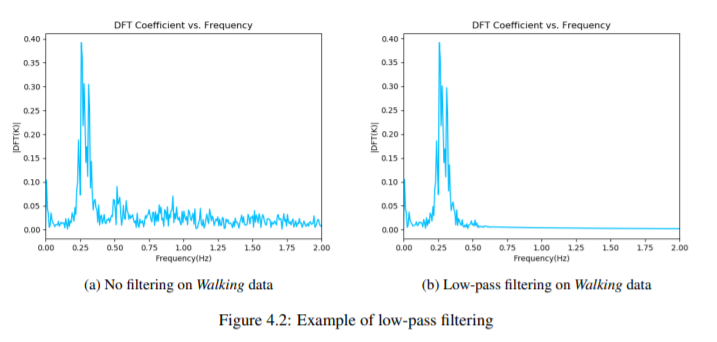

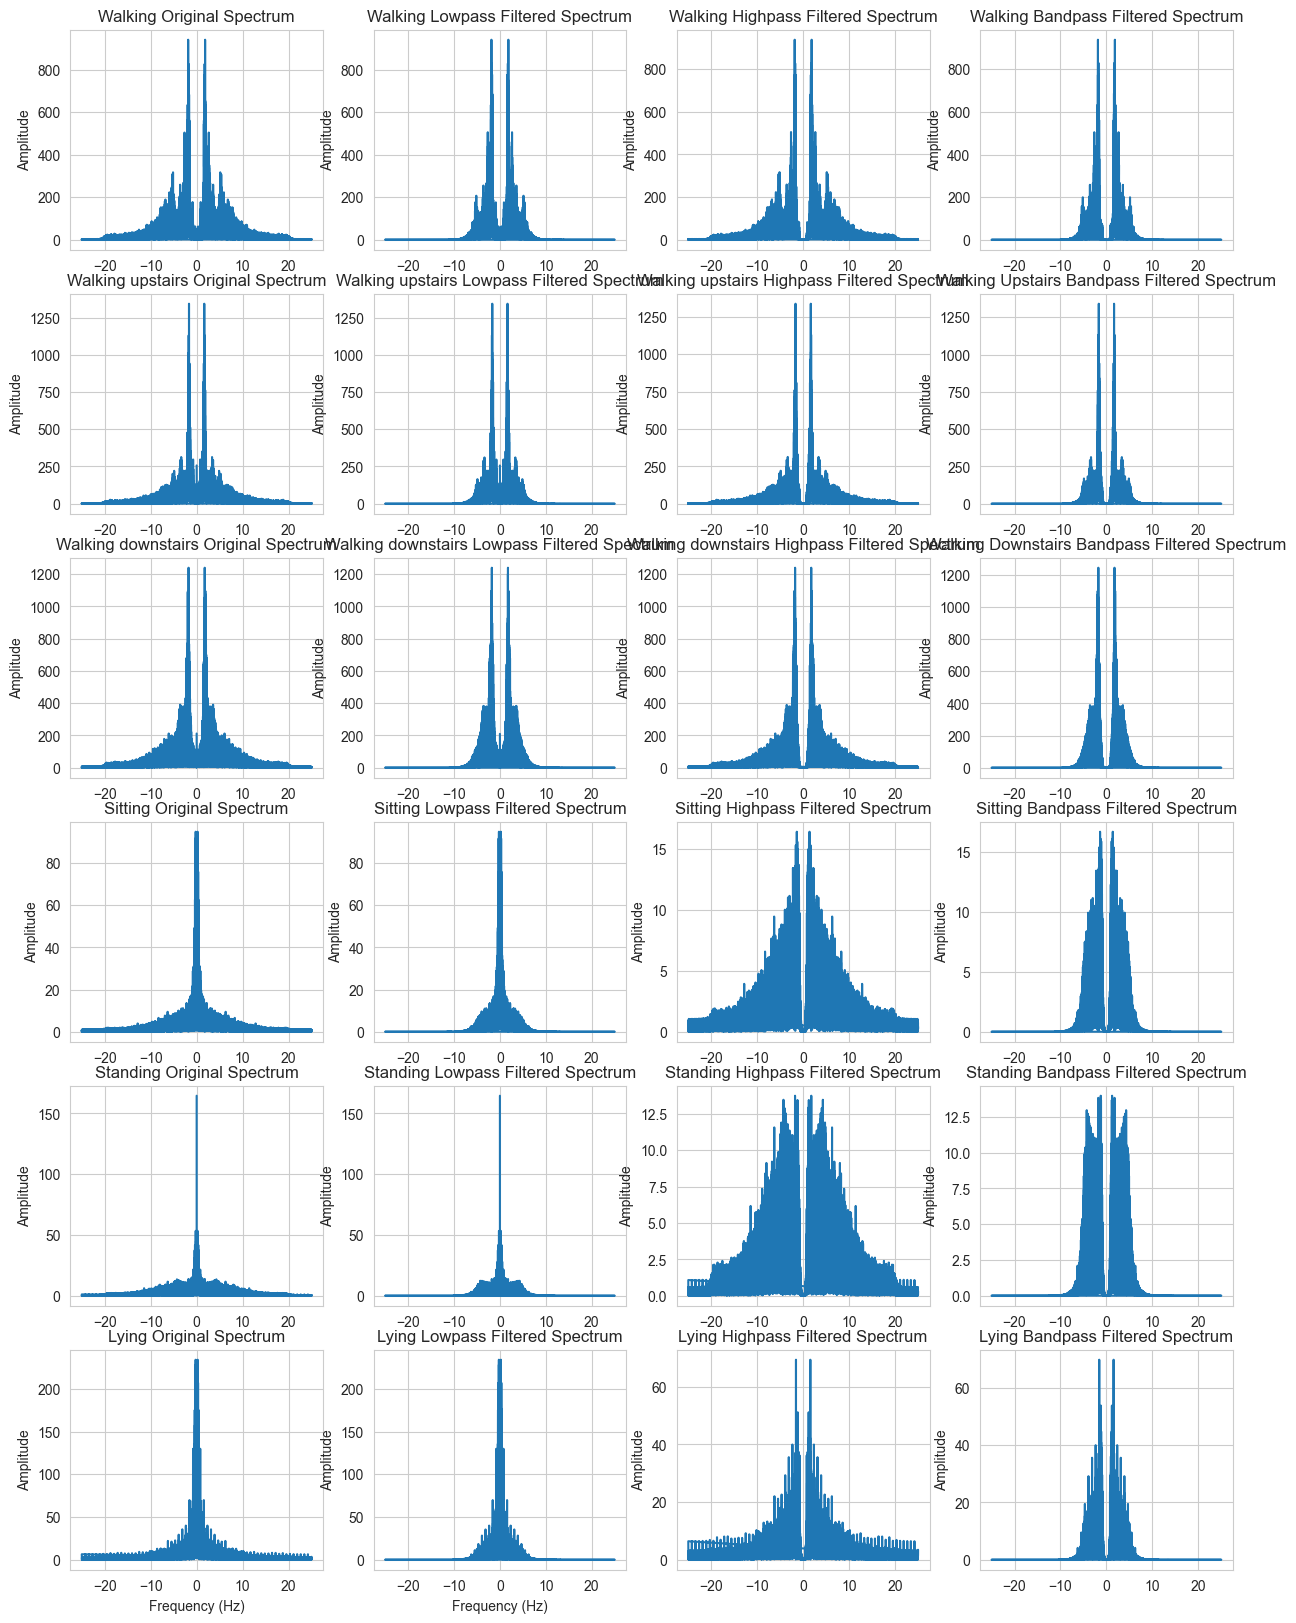

In [16]:
# Define filter parameters
lowcut = 1  # Hz
highcut = 5  # Hz
fs = 50.0  # Sampling rate, in Hz
order = 5  # Order of the filter

# Define filter functions
def butter_lowpass_filter(data, lowcut, fs, order):
    #nyquist_freq = 0.5 * fs
    #low = 2*lowcut / nyquist_freq # command not needed as we specified fs in butter()
    b, a = butter(order, lowcut, btype='lowpass',fs=fs)
    y = lfilter(b, a, data)
    return y

def butter_highpass_filter(data, highcut, fs, order):
    #nyquist_freq = 0.5 * fs
    #high = highcut / nyquist_freq # command not needed as we specified fs in butter()
    b, a = butter(order, highcut, btype='highpass',fs=fs)
    y = lfilter(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyquist_freq = 0.5 * fs
    #low = lowcut / nyquist_freq
    #high = highcut / nyquist_freq # command not needed as we specified fs in butter()
    b, a = butter(order, [lowcut, highcut], btype='bandpass',fs=fs)
    y = lfilter(b, a, data)
    return y

# Apply filters to each activity
walking_lp = butter_lowpass_filter(signal[labels == 1], highcut, fs, order)
walking_hp = butter_highpass_filter(signal[labels == 1], lowcut, fs, order)
walking_bp = butter_bandpass_filter(signal[labels == 1], lowcut, highcut, fs, order)

walking_upstairs_lp = butter_lowpass_filter(signal[labels == 2], highcut, fs, order)
walking_upstairs_hp = butter_highpass_filter(signal[labels == 2], lowcut, fs, order)
walking_upstairs_bp = butter_bandpass_filter(signal[labels == 2], lowcut, highcut, fs, order)

walking_downstairs_lp = butter_lowpass_filter(signal[labels == 3], highcut, fs, order)
walking_downstairs_hp = butter_highpass_filter(signal[labels == 3], lowcut, fs, order)
walking_downstairs_bp = butter_bandpass_filter(signal[labels == 3], lowcut, highcut, fs, order)

sitting_lp = butter_lowpass_filter(signal[labels == 4], highcut, fs, order)
sitting_hp = butter_highpass_filter(signal[labels == 4], lowcut, fs, order)
sitting_bp = butter_bandpass_filter(signal[labels == 4], lowcut, highcut, fs, order)

standing_lp = butter_lowpass_filter(signal[labels == 5], highcut, fs, order)
standing_hp = butter_highpass_filter(signal[labels == 5], lowcut, fs, order)
standing_bp = butter_bandpass_filter(signal[labels == 5], lowcut, highcut, fs, order)

lying_lp = butter_lowpass_filter(signal[labels == 6], highcut, fs, order)
lying_hp = butter_highpass_filter(signal[labels == 6], lowcut, fs, order)
lying_bp = butter_bandpass_filter(signal[labels == 6], lowcut, highcut, fs, order)

# Compute the Fourier transform for each activity and each filter
walking_lp_fft = fft(walking_lp)
walking_bp_fft = fft(walking_bp)
walking_hp_fft = fft(walking_hp)

walking_downstairs_lp_fft = fft(walking_downstairs_lp)
walking_downstairs_bp_fft = fft(walking_downstairs_bp)
walking_downstairs_hp_fft = fft(walking_downstairs_hp)

walking_upstairs_lp_fft = fft(walking_upstairs_lp)
walking_upstairs_bp_fft = fft(walking_upstairs_bp)
walking_upstairs_hp_fft = fft(walking_upstairs_hp)

sitting_lp_fft = fft(sitting_lp)
sitting_bp_fft = fft(sitting_bp)
sitting_hp_fft = fft(sitting_hp)

standing_lp_fft = fft(standing_lp)
standing_bp_fft = fft(standing_bp)
standing_hp_fft = fft(standing_hp)

lying_lp_fft = fft(lying_lp)
lying_bp_fft = fft(lying_bp)
lying_hp_fft = fft(lying_hp)

# Compute the frequency axis for the spectra
sampling_rate = 50 # Hz

walking_freqs = fftfreq(len(walking_fft), 1 / sampling_rate)
walking_upstairs_freqs = fftfreq(len(walking_upstairs_fft), 1 / sampling_rate)
walking_downstairs_freqs = fftfreq(len(walking_downstairs_fft), 1 / sampling_rate)
sitting_freqs = fftfreq(len(sitting_fft), 1 / sampling_rate)
standing_freqs = fftfreq(len(standing_fft), 1 / sampling_rate)
lying_freqs = fftfreq(len(lying_fft), 1 / sampling_rate)

# Plot the spectra of all
fig, axs = plt.subplots(6, 4, figsize=(15, 20))

# Walking
axs[0, 0].plot(walking_freqs, np.abs(walking_fft))
axs[0, 0].set_title("Walking Original Spectrum")
axs[0, 1].plot(walking_freqs, np.abs(walking_lp_fft))
axs[0, 1].set_title("Walking Lowpass Filtered Spectrum")
axs[0, 2].plot(walking_freqs, np.abs(walking_hp_fft))
axs[0, 2].set_title("Walking Highpass Filtered Spectrum")
axs[0, 3].plot(walking_freqs, np.abs(walking_bp_fft))
axs[0, 3].set_title("Walking Bandpass Filtered Spectrum")

# Walking Upstairs
axs[1, 0].plot(walking_upstairs_freqs, np.abs(walking_upstairs_fft))
axs[1, 0].set_title("Walking upstairs Original Spectrum")
axs[1, 1].plot(walking_upstairs_freqs, np.abs(walking_upstairs_lp_fft))
axs[1, 1].set_title("Walking upstairs Lowpass Filtered Spectrum")
axs[1, 2].plot(walking_upstairs_freqs, np.abs(walking_upstairs_hp_fft))
axs[1, 2].set_title("Walking upstairs Highpass Filtered Spectrum")
axs[1, 3].plot(walking_upstairs_freqs, np.abs(walking_upstairs_bp_fft))
axs[1, 3].set_title("Walking Upstairs Bandpass Filtered Spectrum")

# Walking Downstairs
axs[2, 0].plot(walking_downstairs_freqs, np.abs(walking_downstairs_fft))
axs[2, 0].set_title("Walking downstairs Original Spectrum")
axs[2, 1].plot(walking_downstairs_freqs, np.abs(walking_downstairs_lp_fft))
axs[2, 1].set_title("Walking downstairs Lowpass Filtered Spectrum")
axs[2, 2].plot(walking_downstairs_freqs, np.abs(walking_downstairs_hp_fft))
axs[2, 2].set_title("Walking downstairs Highpass Filtered Spectrum")
axs[2, 3].plot(walking_downstairs_freqs, np.abs(walking_downstairs_bp_fft))
axs[2, 3].set_title("Walking Downstairs Bandpass Filtered Spectrum")

# Sitting
axs[3, 0].plot(sitting_freqs, np.abs(sitting_fft))
axs[3, 0].set_title("Sitting Original Spectrum")
axs[3, 1].plot(sitting_freqs, np.abs(sitting_lp_fft))
axs[3, 1].set_title("Sitting Lowpass Filtered Spectrum")
axs[3, 2].plot(sitting_freqs, np.abs(sitting_hp_fft))
axs[3, 2].set_title("Sitting Highpass Filtered Spectrum")
axs[3, 3].plot(sitting_freqs, np.abs(sitting_bp_fft))
axs[3, 3].set_title("Sitting Bandpass Filtered Spectrum")

# Standing
axs[4, 0].plot(standing_freqs, np.abs(standing_fft))
axs[4, 0].set_title("Standing Original Spectrum")
axs[4, 1].plot(standing_freqs, np.abs(standing_lp_fft))
axs[4, 1].set_title("Standing Lowpass Filtered Spectrum")
axs[4, 2].plot(standing_freqs, np.abs(standing_hp_fft))
axs[4, 2].set_title("Standing Highpass Filtered Spectrum")
axs[4, 3].plot(standing_freqs, np.abs(standing_bp_fft))
axs[4, 3].set_title("Standing Bandpass Filtered Spectrum")

# Lying
axs[5, 0].plot(lying_freqs, np.abs(lying_fft))
axs[5, 0].set_title("Lying Original Spectrum")
axs[5, 1].plot(lying_freqs, np.abs(lying_lp_fft))
axs[5, 1].set_title("Lying Lowpass Filtered Spectrum")
axs[5, 2].plot(lying_freqs, np.abs(lying_hp_fft))
axs[5, 2].set_title("Lying Highpass Filtered Spectrum")
axs[5, 3].plot(lying_freqs, np.abs(lying_bp_fft))
axs[5, 3].set_title("Lying Bandpass Filtered Spectrum")

# Set y-axis labels
for ax in axs.flat:
    ax.set_ylabel('Amplitude')

# Set x-axis labels
axs[-1, 0].set_xlabel('Frequency (Hz)')
axs[-1, 1].set_xlabel('Frequency (Hz)')
plt.show()

**c)** Report which of the filters is better for each of the activity and what settings you have used.

>your answer : For lying, standing, and sitting, a lowpass filter with a cutoff frequency of 5 Hz is ideal because most of the signal power is concentrated in the lower frequencies. My choice was a Butterworth filter with a cutoff frequency of 5 Hz and a filter order of 5.

For the walking activities, a bandpass filter is preferred because the signal power is spread across a range of frequencies. By using a bandpass filter, we can remove the noise outside of this range while retaining the signal of interest. My choice was aButterworth filter with a low cutoff frequency of 1 Hz and a high cutoff frequency of 5 Hz and a filter order of 5.

**End of Exercise 4.7**

#### Dynamic Time Warping and Classification with K-nearest Neighbours

Now that the dataset has been explored and the pre-processing of data has been handled, it is time to perform actual classification of the 6 activities. We cannot however just classify the raw signals or feature signals as is, since the signals differ in length and general structure. Even though the data from a walking activity is produced by walking, not all walking signals will be the same since everyone walks in a different manner and the signals may thus vary in time and speed. One way to measure the similarity between two time series is Dynamic Time Warping (DTW). For a very intuitive explanation you can turn to reference [9]. A Python Notebook by Punbatra [10] explains the algorithm with a hands on approach. The more theoretical background can be found in Chapter 4 of the book by Muller [11]. Once we have computed the similarity ¨between signals, we can group or cluster the signals that are similar. These clustered signals likely belong to the same class (activity). A classifier can be trained on examples of signals from the train set and use this information to determine what activity the signals in the test set belongs to. One classifier that can beused is the K-nearest Neighbour classifier. An intuitive explanation of the classifier is given in reference [12]. Some theoretical background can be found in Chapter 3.1 and 3.2 in the book by Murty [13]. Simple classifiers such as K-Nearest Neighbors can achieve high accuracy while using DTW as a distance metric
for classifying/clustering time series data.

**Additional References for your perusal**: 

[9] Explanation of DTW presented by Thales Sehn Korting ¨ https://www.youtube.com/watch?v=_K1OsqCicBY Please copy the link, clicking may not work.

[10] Nipun Batra gives a more practical approach to the DTW algorithm in this Python example https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/dtw.ipynb
Please copy the link, clicking may not work.

[11] The book Information Retrieval for Music and Motion by Meinard Muller. You can read Chapter 4 ¨
for the information about Dynamic Time warping. The book is accessible with your student account
via the following link. https://link-springer-com.ezproxy2.utwente.nl/content/pdf/10.1007%2F978-3-540-74048-3.pdf Please copy the link, clicking may not work.

[12] Video on KNN classification by Augmented Startups https://www.youtube.com/watch?v=MDniRwXizWo Please copy the link, clicking may not work.

#### Exercise 4.8 
**a)** The tutorial in reference [13] applies DTW on derived features from the activity recognition data set. Apply the same technique but now on the raw data (all the raw data present in this dataset!). Include the classification results (the confusion matrices) for both the feature data and the raw data and reflect on the results and the differences. The complete classification of the tutorial can take very long (hours!) depending on your computer. It is okay if you leave on your laptop overnight, but if things take too long it is also fine to apply the classifier on a subset of the data. However, then you can expect that the performance in classification will be less (generally the more data the better) and you should mention this. The code allows you to play with the number of neighbours (parameter k) if you would like to see how this changes classification performance. 

**Reference:(This is to assist you in completing this exercise)** 

[13] Python tutorial on DTW and KNN classification of the UCI Har dataset by Mark Regan.
https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb Please copy the link,
clicking may not work.

**Note:** The code is already copied below for your ease of reference. 


In [17]:
#Given functions from the tutorial
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for KNN
    max_warping_window : int, optional (default = infinity)
    Maximum warping window allowed by the DTW dynamicprogramming function
    subsample_step : int, optional (default = 1)
    Step size for the timeseries array. By setting subsample_step = 2,
    the timeseries length will be reduced by 50% because every second
    item is skipped. Implemented by x[:, ::subsample_step]
    """
    def __init__(self, n_neighbors=5, max_warping_window=10000,subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Training data set for input into KNN classifer
        l : array of shape [n_samples]
        Training labels for input into KNN classifier
        """
        self.x = x
        self.l = l
    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.
        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared
        d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function
        Returns
        -------
        DTW distance between A and B"""
    #      Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = float('inf') * np.ones((M, N))
        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i - 1, 0] + d(ts_a[i], ts_b[0])
        for j in range(1, N):
            cost[0, j] = cost[0, j - 1] + d(ts_a[0], ts_b[j])
        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j - 1], cost[i - 1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])
            # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        y : array of shape [n_samples, n_timepoints]
        Returns
        -------
        Distance matrix between each item of x and y with
        shape [training_n_samples, testing_n_samples]
        """
        # Compute the distance matrix
        dm_count = 0
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if (np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            p = ProgressBar(shape(dm)[0])
            for i in tqdm(xrange(0, x_s[0] - 1)): #tqdm for progress bar
                for j in xrange(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
                    # Convert to squareform
                    dm = squareform(dm)
            return dm
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0] * y_s[0]
            p = ProgressBar(dm_size)
            for i in tqdm(range(0, x_s[0])): #tqdm is used to print the progress
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
#                     p.animate(dm_count) # progressbar was being used here
            return dm
   
    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        Array containing the testing data set to be classified
        4
        Returns
        -------
        2 arrays representing:
        (1) the predicted class labels
        (2) the knn label count probability"""
        dm = self._dist_matrix(x, self.x)
        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors
        return mode_label.ravel(), mode_proba.ravel()

#Progressbar is not used because of a bug which prints the progress in next line. 
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 50
        self.__update_amount(0)

    def animate(self, iter):
        print('\r', self, end='')
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

100%|██████████| 300/300 [1:18:35<00:00, 15.72s/it]


Confusion matrix and metrics for dataset with features

                    precision    recall  f1-score   support

           WALKING       0.98      0.95      0.97        62
  WALKING UPSTAIRS       0.97      0.92      0.94        37
WALKING DOWNSTAIRS       0.89      0.98      0.93        41
           SITTING       0.78      0.50      0.61        78
          STANDING       0.36      0.77      0.49        26
            LAYING       0.89      0.86      0.87        56

          accuracy                           0.80       300
         macro avg       0.81      0.83      0.80       300
      weighted avg       0.84      0.80      0.81       300



100%|██████████| 300/300 [12:19<00:00,  2.47s/it]


Confusion matrix and metrics for body_acc_x

                    precision    recall  f1-score   support

           WALKING       0.88      0.95      0.91        56
  WALKING UPSTAIRS       0.94      0.56      0.70        59
WALKING DOWNSTAIRS       0.56      1.00      0.71        25
           SITTING       0.66      0.38      0.48        88
          STANDING       0.29      0.39      0.33        41
            LAYING       0.31      0.55      0.40        31

          accuracy                           0.59       300
         macro avg       0.61      0.64      0.59       300
      weighted avg       0.66      0.59      0.59       300



100%|██████████| 300/300 [12:52<00:00,  2.58s/it]


Confusion matrix and metrics for body_acc_y

                    precision    recall  f1-score   support

           WALKING       0.20      0.39      0.26        31
  WALKING UPSTAIRS       0.91      0.36      0.52        88
WALKING DOWNSTAIRS       0.38      0.94      0.54        18
           SITTING       0.42      0.34      0.38        62
          STANDING       0.34      0.42      0.38        45
            LAYING       0.54      0.52      0.53        56

          accuracy                           0.43       300
         macro avg       0.46      0.50      0.43       300
      weighted avg       0.55      0.43      0.44       300



100%|██████████| 300/300 [12:52<00:00,  2.57s/it]


Confusion matrix and metrics for body_acc_z

                    precision    recall  f1-score   support

           WALKING       0.20      0.44      0.28        27
  WALKING UPSTAIRS       0.97      0.34      0.50       101
WALKING DOWNSTAIRS       0.07      0.33      0.11         9
           SITTING       0.48      0.32      0.38        75
          STANDING       0.32      0.31      0.32        58
            LAYING       0.31      0.57      0.40        30

          accuracy                           0.36       300
         macro avg       0.39      0.39      0.33       300
      weighted avg       0.56      0.36      0.39       300



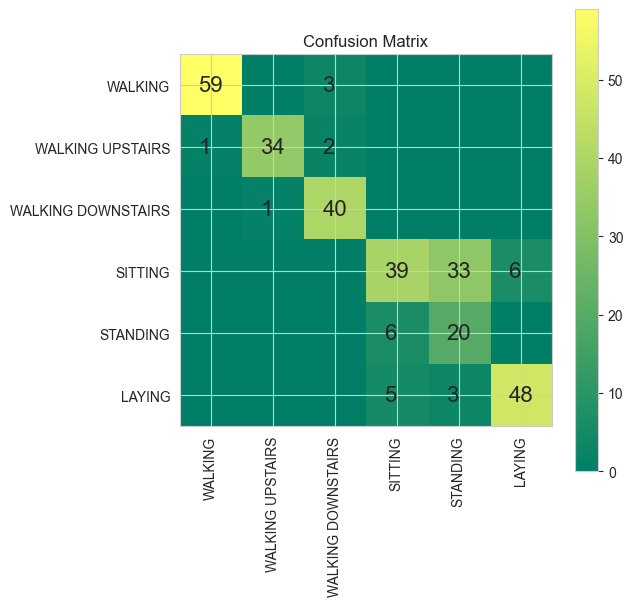

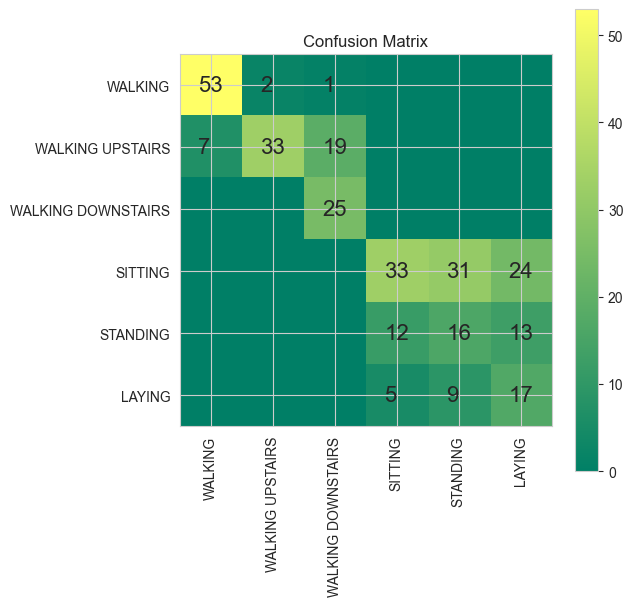

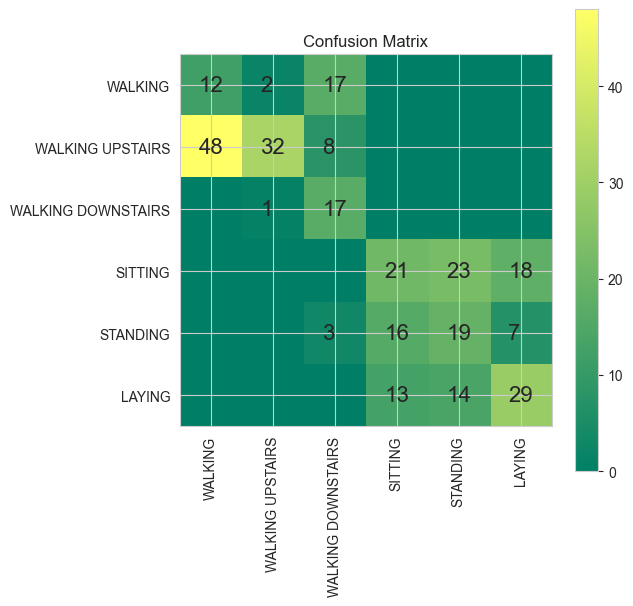

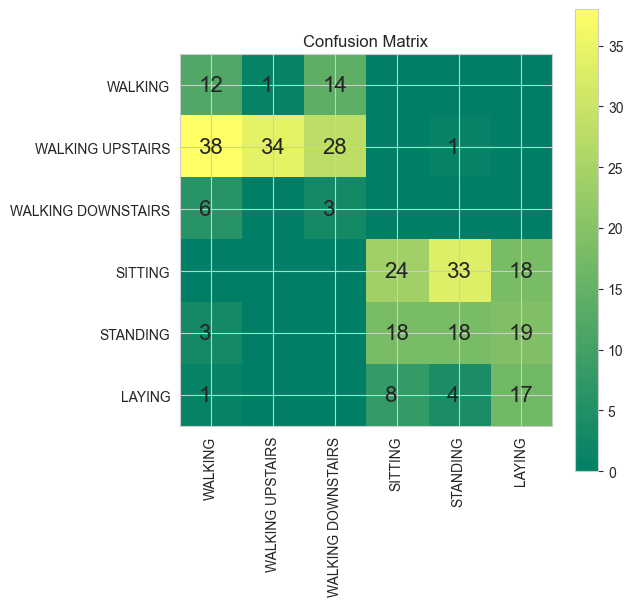

In [18]:
# Mapping table for classes
lab = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Function to show confusion matrix and metrics
def calulate_show_metrics(pred_labels, true_labels, lab=lab):
    print(classification_report(pred_labels, true_labels,
                                target_names=[l for l in lab.values()]))

    conf_mat = confusion_matrix(pred_labels, true_labels)

    fig = plt.figure(figsize=(6,6))
    width = np.shape(conf_mat)[1]
    height = np.shape(conf_mat)[0]

    res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
    for i, row in enumerate(conf_mat):
        for j, c in enumerate(row):
            if c>0:
                plt.text(j-.2, i+.1, c, fontsize=16)
    cb = fig.colorbar(res)
    plt.title('Confusion Matrix')
    _ = plt.xticks(range(6), [l for l in lab.values()], rotation=90)
    _ = plt.yticks(range(6), [l for l in lab.values()])

# Load the raw test data
body_acc_x_test = pd.read_fwf(main_dir + 'test/Inertial Signals/body_acc_x_test.txt', header=None, delim_whitespace=True)
body_acc_y_test = pd.read_fwf(main_dir + 'test/Inertial Signals/body_acc_y_test.txt', header=None, delim_whitespace=True)
body_acc_z_test = pd.read_fwf(main_dir + 'test/Inertial Signals/body_acc_z_test.txt', header=None, delim_whitespace=True)

# Transform all the raw data from panda dataframes to np arrays so KnnDtw will work
body_acc_x_train = np.array(body_acc_x_train)
body_acc_x_test = np.array(body_acc_x_test)
body_acc_y_train = np.array(body_acc_y_train)
body_acc_y_test = np.array(body_acc_y_test)
body_acc_z_train = np.array(body_acc_z_train)
body_acc_z_test = np.array(body_acc_z_test)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_test = np.array(X_test)
X_train = np.array(X_train)

subset = 300
n_neighbors = 5
max_warping_window = 30

# 1
classifier_features = KnnDtw(n_neighbors=n_neighbors, max_warping_window=max_warping_window)
classifier_features.fit(X_train[subset:(subset+subset)], Y_train[subset:(subset+subset)])
label_features, proba_features = classifier_features.predict(X_test[subset:(subset+subset)])
print("Confusion matrix and metrics for dataset with features\n")
calulate_show_metrics(pred_labels=label_features, true_labels=Y_test[subset:(subset+subset)], lab=lab)

# 2
classifier_raw1 = KnnDtw(n_neighbors=n_neighbors, max_warping_window=max_warping_window)
classifier_raw1.fit(body_acc_x_train[subset:(subset+subset)], Y_train[subset:(subset+subset)])
label_raw1, proba_raw1 = classifier_raw1.predict(body_acc_x_test[subset:(subset+subset)])
print("Confusion matrix and metrics for body_acc_x\n")
calulate_show_metrics(pred_labels=label_raw1, true_labels=Y_test[subset:(subset+subset)], lab=lab)

# 3
classifier_raw2 = KnnDtw(n_neighbors=n_neighbors, max_warping_window=max_warping_window)
classifier_raw2.fit(body_acc_y_train[subset:(subset+subset)], Y_train[subset:(subset+subset)])
label_raw2, proba_raw2 = classifier_raw2.predict(body_acc_y_test[subset:(subset+subset)])
print("Confusion matrix and metrics for body_acc_y\n")
calulate_show_metrics(pred_labels=label_raw2, true_labels=Y_test[subset:(subset+subset)], lab=lab)

# 4
classifier_raw3 = KnnDtw(n_neighbors=n_neighbors, max_warping_window=max_warping_window)
classifier_raw3.fit(body_acc_z_train[subset:(subset+subset)], Y_train[subset:(subset+subset)])
label_raw3, proba_raw3 = classifier_raw3.predict(body_acc_z_test[subset:(subset+subset)])
print("Confusion matrix and metrics for body_acc_z\n")
calulate_show_metrics(pred_labels=label_raw3, true_labels=Y_test[subset:(subset+subset)], lab=lab)


**b)** Also reflect on the ability to discriminate between the 6 activities. Note that the DTW algorithm uses brute force to compare all aspects of a signal.

> The confusion matrices and classification reports calculated for each of the 4 KNN-DTW classifiers suggest that the model is able to distinguish between the 6 activities with a reasonable degree of accuracy.The fact that the algorithm uses brute force to compare all aspects of a signal is both an advantage and a disadvantage. On the one hand, we capture complex relationships between different parts of the signal, which can lead to better accuracy. On the other hand, it can be computationally expensive and slow, especially when dealing with large datasets or complex signals!!
Furthermore, the performance of the model may depend on the subset of the data used for training and testing, as well as the choice of hyperparameters such as the number of neighbors and the maximum warping window. Therefore, it's important to evaluate the model's performance on different subsets and with different hyperparameter values to get a more comprehensive understanding of its ability to discriminate between the 6 activities. This "exploration" of the hyperparameters is also computationally expensive!.

### Time Series Comparison and Prediction

For this assignment, we will switch to another dataset, namely the Kaggle Berkeley Earth Surface Temperature Study dataset. This dataset can be downloaded from reference [14]. This extensive data set is created by combining multiple existing archives and it allows groupings by country or city of interest. The dataset does not need an explanation as with the UCI HAR dataset and its usage is straightforward.

**Reference:** 

[14] Berkeley EarthSurface Temperature Study dataset. Accessible via the link below. 
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data Please copy the link, clicking may not work.

**Reading Material (This is to assist you in completing this exercise)**

Time series prediction
1. https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb
2. https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/


#### Exercise 4.9 
**a)** Plot the yearly temperatures for Norway, Finland, Singapore and Cambodia. Use DTW to measure the similarities between the temperature data of these countries and reflect on the results.

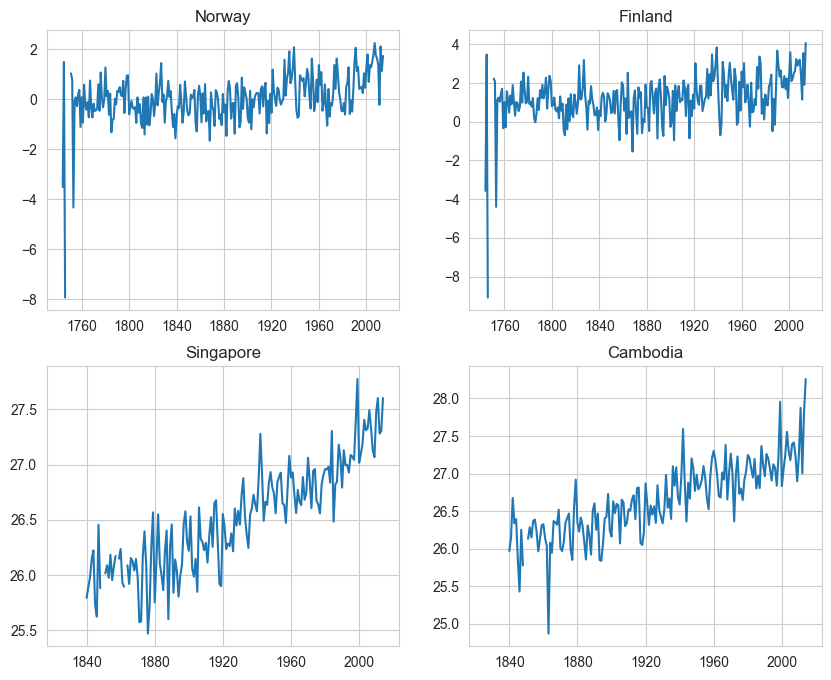

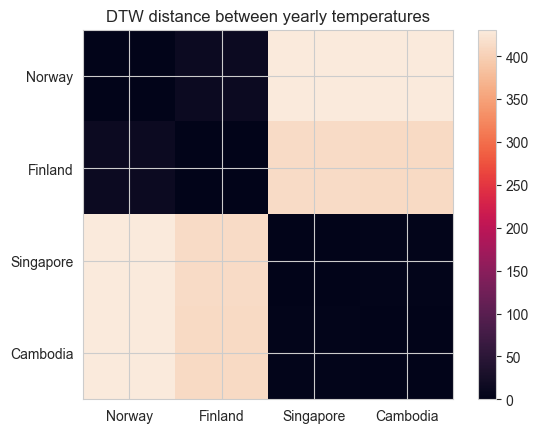

In [20]:
data_dir = "C:/Users/s3084493/OneDrive - University of Twente/MSc Robotics/Quarter 3/Data Science/Assignments/TimeSeries/Earth Surface Temperature Data/"

# Load necessary CSV files
GlobalLandTemperaturesByCity = pd.read_csv(data_dir + "GlobalLandTemperaturesByCity.csv")
GlobalLandTemperaturesByCountry = pd.read_csv(data_dir + "GlobalLandTemperaturesByCountry.csv")

# Extract temperature data for Norway, Finland, Singapore, and Cambodia
norway_temps = GlobalLandTemperaturesByCountry[(GlobalLandTemperaturesByCountry['Country'] == 'Norway') &
                                               (GlobalLandTemperaturesByCountry['dt'] >= '1700-01-01')][['dt', 'AverageTemperature']]
finland_temps = GlobalLandTemperaturesByCountry[(GlobalLandTemperaturesByCountry['Country'] == 'Finland') &
                                                (GlobalLandTemperaturesByCountry['dt'] >= '1700-01-01')][['dt', 'AverageTemperature']]
singapore_temps = GlobalLandTemperaturesByCountry[(GlobalLandTemperaturesByCountry['Country'] == 'Singapore') &
                                                  (GlobalLandTemperaturesByCountry['dt'] >= '1700-01-01')][['dt', 'AverageTemperature']]
cambodia_temps = GlobalLandTemperaturesByCountry[(GlobalLandTemperaturesByCountry['Country'] == 'Cambodia') &
                                                 (GlobalLandTemperaturesByCountry['dt'] >= '1700-01-01')][['dt', 'AverageTemperature']]

# Convert date strings to datetime objects and set as index
norway_temps['dt'] = pd.to_datetime(norway_temps['dt'])
norway_temps.set_index('dt', inplace=True)

finland_temps['dt'] = pd.to_datetime(finland_temps['dt'])
finland_temps.set_index('dt', inplace=True)

singapore_temps['dt'] = pd.to_datetime(singapore_temps['dt'])
singapore_temps.set_index('dt', inplace=True)

cambodia_temps['dt'] = pd.to_datetime(cambodia_temps['dt'])
cambodia_temps.set_index('dt', inplace=True)

# Resample to yearly data and plot
norway_temps_yearly = norway_temps.resample('Y').mean()
finland_temps_yearly = finland_temps.resample('Y').mean()
singapore_temps_yearly = singapore_temps.resample('Y').mean()
cambodia_temps_yearly = cambodia_temps.resample('Y').mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(norway_temps_yearly)
axs[0, 0].set_title('Norway')
axs[0, 1].plot(finland_temps_yearly)
axs[0, 1].set_title('Finland')
axs[1, 0].plot(singapore_temps_yearly)
axs[1, 0].set_title('Singapore')
axs[1, 1].plot(cambodia_temps_yearly)
axs[1, 1].set_title('Cambodia')

plt.show()

# Remove NaN values by interpolation
norway_temps_yearly = norway_temps_yearly.interpolate()
finland_temps_yearly = finland_temps_yearly.interpolate()
singapore_temps_yearly = singapore_temps_yearly.interpolate()
cambodia_temps_yearly = cambodia_temps_yearly.interpolate()

# Compute distance matrix
distances = np.zeros((4, 4))
countries = ['Norway', 'Finland', 'Singapore', 'Cambodia']
temps_yearly = [norway_temps_yearly, finland_temps_yearly, singapore_temps_yearly, cambodia_temps_yearly]

for i in range(4):
    for j in range(4):
        distances[i, j] = dtw(temps_yearly[i], temps_yearly[j])

# Display distance matrix as heatmap
fig, ax = plt.subplots()
im = ax.imshow(distances)

# Add axis labels and tick marks
ax.set_xticks(np.arange(len(countries)))
ax.set_yticks(np.arange(len(countries)))
ax.set_xticklabels(countries)
ax.set_yticklabels(countries)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title
ax.set_title('DTW distance between yearly temperatures')

# Show plot
plt.show()



From the heatmap, we can see that Norway and Finland have the smallest distance, indicating that their yearly temperature profiles are the most similar. Singapore and Cambodia also have a very small distance between them, indicating that their yearly temperature profiles are also very similar. On contrast, Norway has the largest distance with Singapore and Cambodia, which shows that their temperature profiles are the least similar.These results are consistent with our visual inspection of the temperature plots earlier.

**b)** Look at the tutorial on time series data by Aarshay Jain [15]. Use the Dickey-Fuller test to evaluate the stationarity of the temperature data for the four countries.

**Reference:** 

[15] Time Series Modelling and Forecastig by Aarshay Jain. Tutorial and Python code can be accessed through the link below. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ Please copy the link, clicking may not work.


Results of Dickey-Fuller Test for Norway:
Test Statistic                  -2.943057
p-value                          0.040565
#Lags Used                      10.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64

Results of Dickey-Fuller Test for Finland:
Test Statistic                  -2.082016
p-value                          0.251807
#Lags Used                      13.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64

Results of Dickey-Fuller Test for Singapore:
Test Statistic                   1.130619
p-value                          0.995470
#Lags Used                      10.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.8779

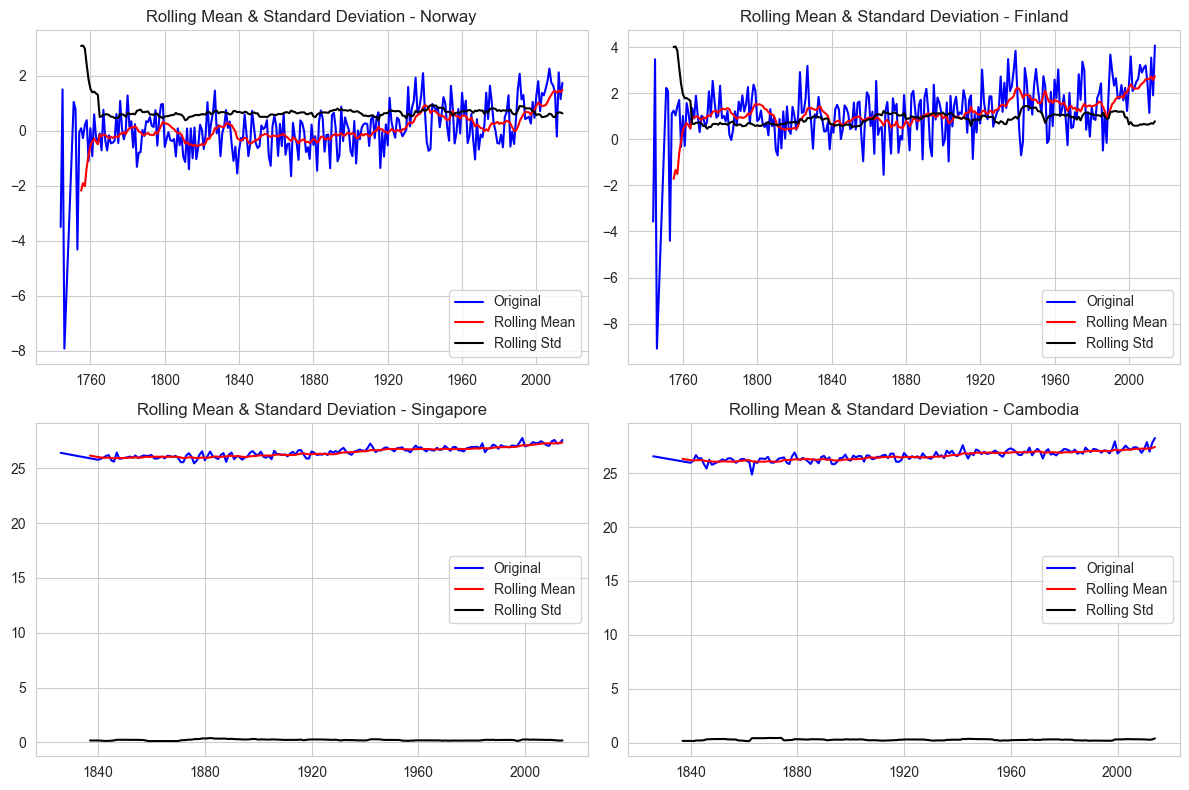

In [21]:
def test_stationarity(timeseries, ax, country_name):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    ax.plot(timeseries, color='blue', label='Original')
    ax.plot(rolmean, color='red', label='Rolling Mean')
    ax.plot(rolstd, color='black', label='Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation - ' + country_name)

    # Perform Dickey-Fuller test:
    print('\nResults of Dickey-Fuller Test for ' + country_name + ':')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# Create the figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot each time series in a separate subplot
test_stationarity(norway_temps_yearly, axs[0, 0], country_name="Norway")
test_stationarity(finland_temps_yearly, axs[0, 1], country_name="Finland")
test_stationarity(singapore_temps_yearly, axs[1, 0], country_name="Singapore")
test_stationarity(cambodia_temps_yearly, axs[1, 1], country_name="Cambodia")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

The Dickey-Fuller test results for these 4 countries suggest the following:

Norway: The test statistic of -2.94 indicates that the time series is stationary with a 95% confidence interval, since it is larger than the critical values at the 1% and smaller than the 5% level (-3.46 and -2.87, respectively). The p-value of 0.041 is also smaller than the 0.05 significance level.

Finland: The test statistic of -2.08 is greater than the critical values at the 1%, 5%, and 10% level. This suggests that the time series is not stationary.

Singapore: The test statistic of 1.13 is greater than all critical values, indicating that the null hypothesis  cannot be rejected and is therefore not stationary. The p-value of 0.995 further supports this conclusion.

Cambodia: The test statistic of 0.68 and the p-value of 0.989 suggest that the null hypothesis cannot be rejected, and thus the time series is non-stationary.

**c)** Temperature and weather data includes seasons, day and night temperature changes as well as global warming. This seasonality and the slow trends (such as global warming) can be removed by differencing and decomposition techniques. Apply these techniques from the tutorial to de-trend the data and remove seasonality. Again apply DTW on your newly obtained processed data and reflect on the results.
> your answer Looking at the new heatmap (below), we can see that the distances have decreased for all pairs of signals. This indicates that making the signals stationary has made them more similar to each other in terms of their temporal patterns.


Results of Dickey-Fuller Test for Norway:
Test Statistic                -8.246406e+00
p-value                        5.538893e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64

Results of Dickey-Fuller Test for Finland:
Test Statistic                -8.527631e+00
p-value                        1.058585e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.600000e+02
Critical Value (1%)           -3.455754e+00
Critical Value (5%)           -2.872721e+00
Critical Value (10%)          -2.572728e+00
dtype: float64

Results of Dickey-Fuller Test for Singapore:
Test Statistic                -7.457549e+00
p-value                        5.461634e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
C

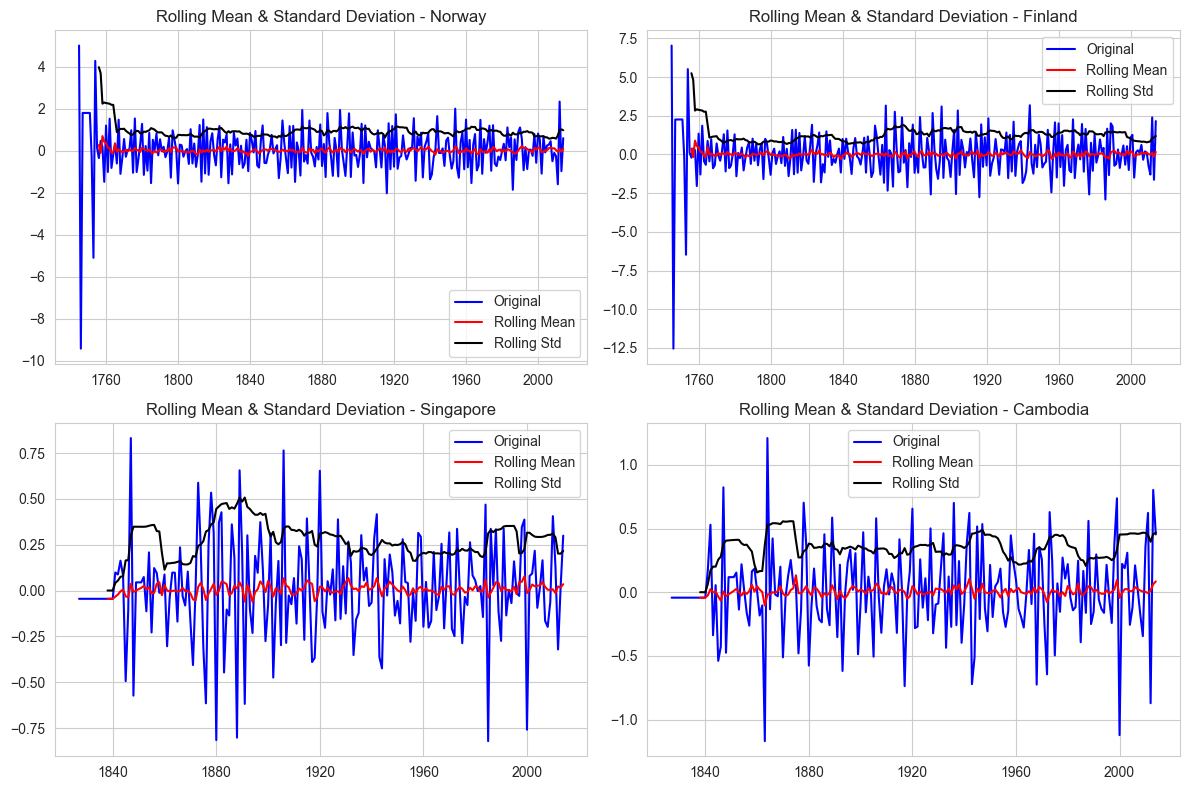

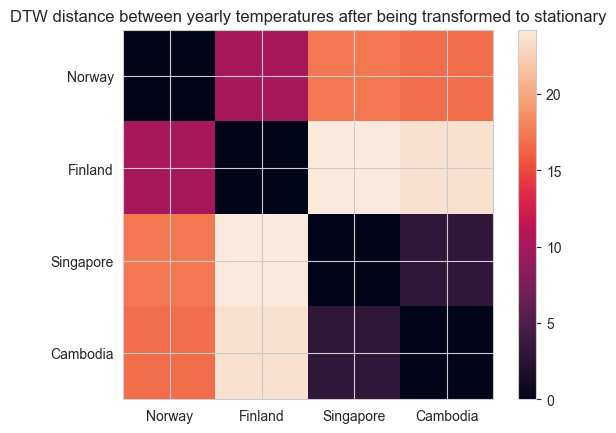

In [22]:
# (c)
# Remove seasonality and trend from data by taking first order differences (make signal stationary)
norway_temps_yearly_stat = norway_temps_yearly - norway_temps_yearly.shift()
norway_temps_yearly_stat.dropna(inplace=True)

finland_temps_yearly_stat = finland_temps_yearly - finland_temps_yearly.shift()
finland_temps_yearly_stat.dropna(inplace=True)

singapore_temps_yearly_stat = singapore_temps_yearly - singapore_temps_yearly.shift()
singapore_temps_yearly_stat.dropna(inplace=True)

cambodia_temps_yearly_stat = cambodia_temps_yearly - cambodia_temps_yearly.shift()
cambodia_temps_yearly_stat.dropna(inplace=True)
# Visually check whether new signals are stationary
# Create the figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot each time series in a separate subplot
test_stationarity(norway_temps_yearly_stat, axs[0, 0], country_name="Norway")
test_stationarity(finland_temps_yearly_stat, axs[0, 1], country_name="Finland")
test_stationarity(singapore_temps_yearly_stat, axs[1, 0], country_name="Singapore")
test_stationarity(cambodia_temps_yearly_stat, axs[1, 1], country_name="Cambodia")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


# Compute distance matrix (dtw)
distances = np.zeros((4, 4))
countries = ['Norway', 'Finland', 'Singapore', 'Cambodia']
temps_yearly_stationary = [norway_temps_yearly_stat, finland_temps_yearly_stat, singapore_temps_yearly_stat, cambodia_temps_yearly_stat]

for i in range(4):
    for j in range(4):
        distances[i, j] = dtw(temps_yearly_stationary[i], temps_yearly_stationary[j])

# Display distance matrix as heatmap
fig, ax = plt.subplots()
im = ax.imshow(distances)

# Add axis labels and tick marks
ax.set_xticks(np.arange(len(countries)))
ax.set_yticks(np.arange(len(countries)))
ax.set_xticklabels(countries)
ax.set_yticklabels(countries)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title
ax.set_title('DTW distance between yearly temperatures after being transformed to stationary')

# Show plot
plt.show()

**d)** Read the section on Forecasting models in the tutorial and apply the AR, AM and ARIMA model on the temperature data of one of the four countries. Reflect on the results of the models on the data. Be clear in your methodology and explain which values for p, q and d you use based on the ACF and PACF plots.

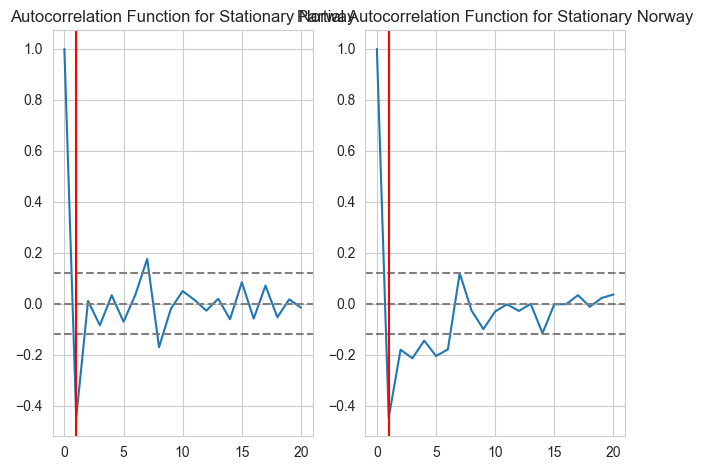

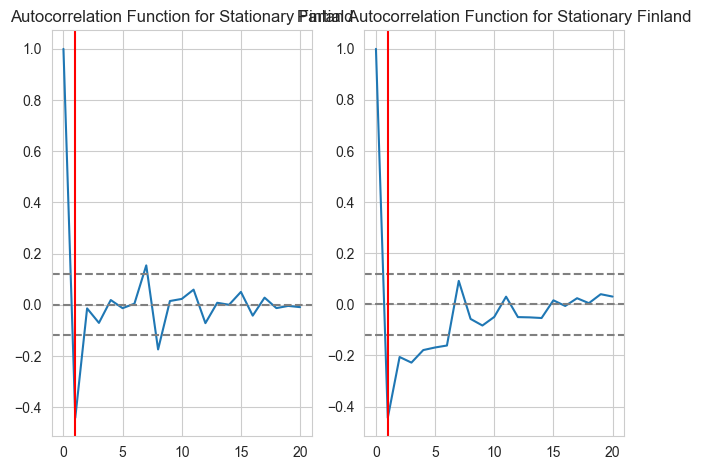

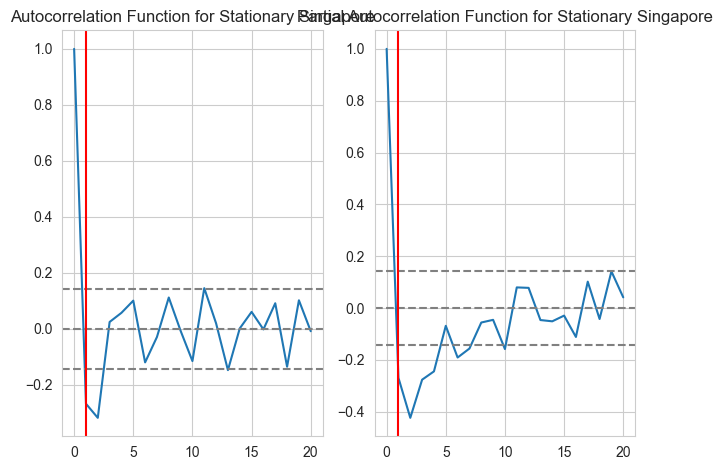

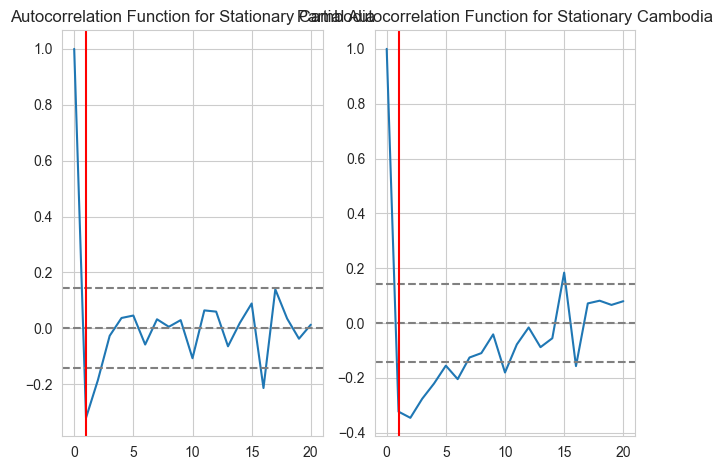

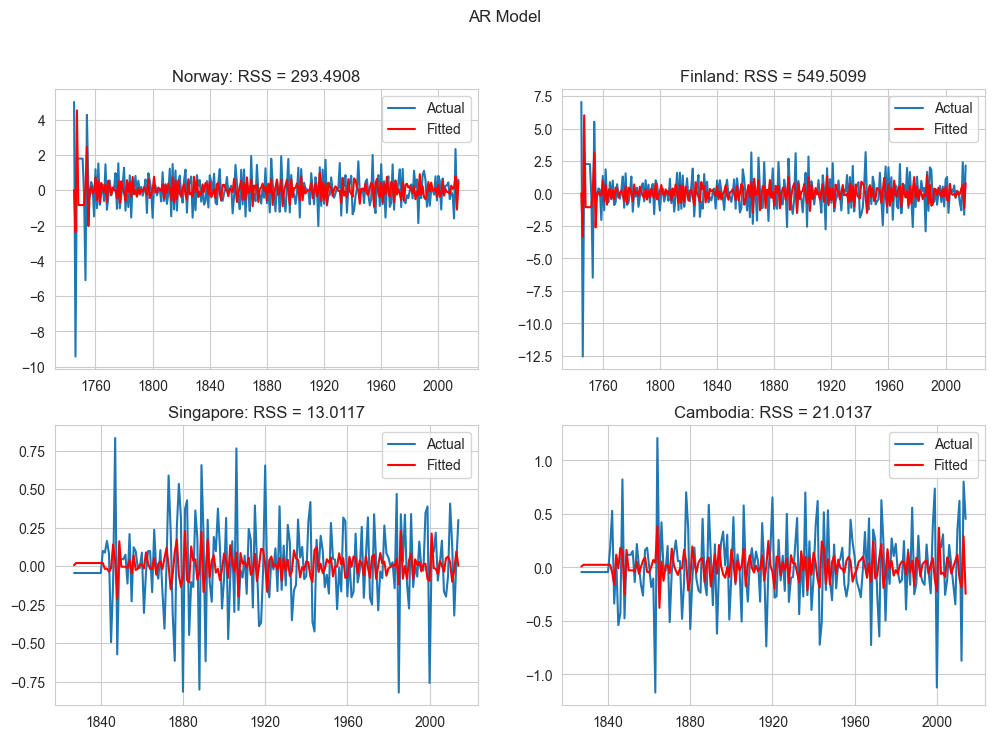

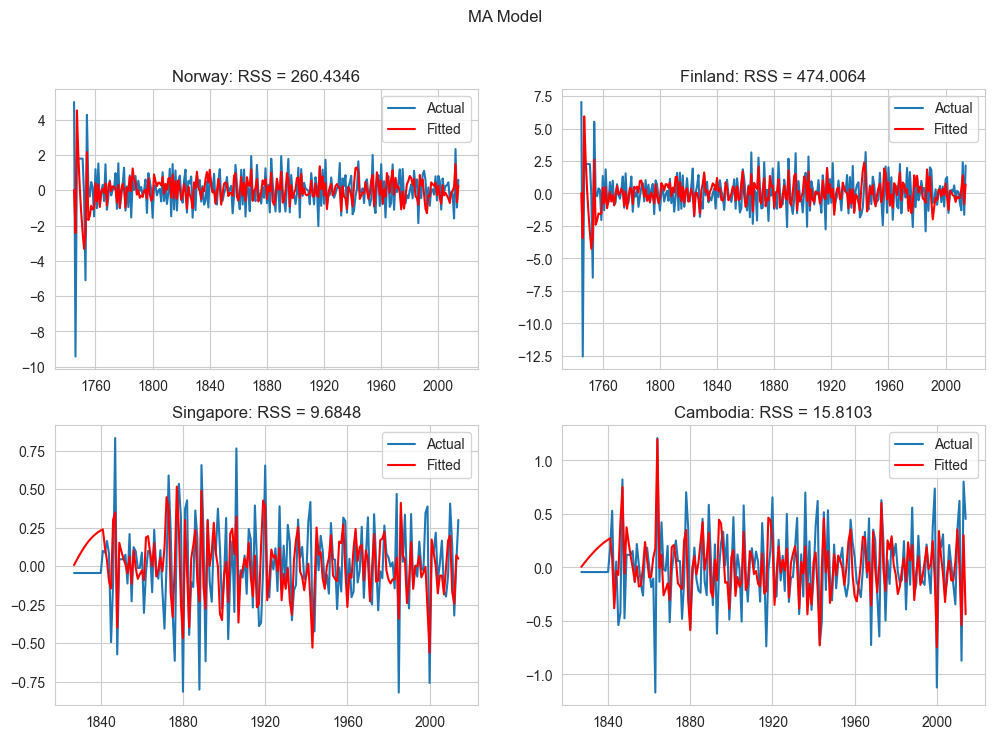

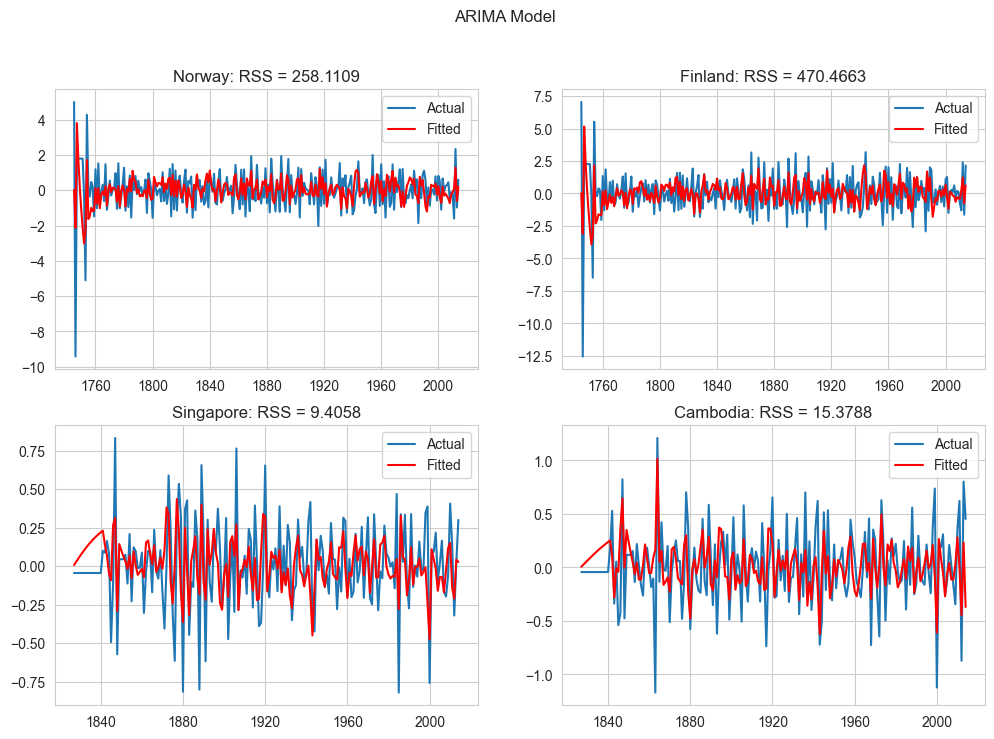

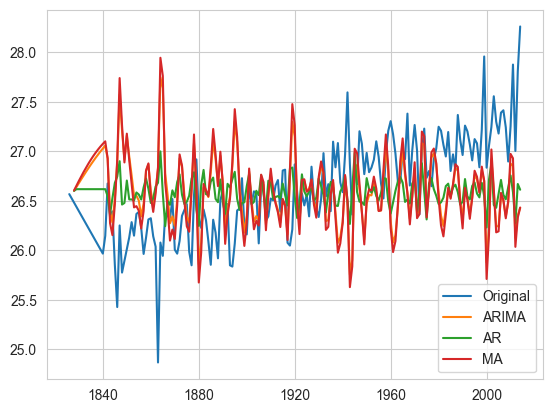

In [23]:
for i, country_temp_stationary in enumerate(temps_yearly_stationary):
    lag_acf = acf(country_temp_stationary, nlags=20)
    lag_pacf = pacf(country_temp_stationary, nlags=20, method='ols')
    # Create new figure
    fig = plt.figure()
    # Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(country_temp_stationary)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(country_temp_stationary)), linestyle='--', color='gray')
    plt.axvline(x=(np.where((lag_acf < 4 / np.sqrt(len(country_temp_stationary)))))[0][0], color = 'r')
    plt.title('Autocorrelation Function for Stationary ' + countries[i])
    # Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(country_temp_stationary)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(country_temp_stationary)), linestyle='--', color='gray')
    plt.axvline(x=(np.where((lag_pacf < 4 / np.sqrt(len(country_temp_stationary)))))[0][0], color = 'r')
    plt.title('Partial Autocorrelation Function for Stationary ' + countries[i])
    plt.tight_layout()
    # Display the figure
    plt.show()


# p – is 1 for all 4 countries and q – is 1 for all 4 countries


# AR model
# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Set the super title for the plot
fig.suptitle('AR Model')
for i, country_temp_stationary in enumerate(temps_yearly_stationary):
    row = i // 2
    col = i % 2

    # Fit the AR model
    model = ARIMA(country_temp_stationary, order=(1, 0, 0))
    results_AR = model.fit(method='innovations_mle')

    country_temp_stationary = country_temp_stationary.squeeze()

    # Plot the time series and the fitted values on the current axis
    axes[row, col].plot(country_temp_stationary, label='Actual')
    axes[row, col].plot(results_AR.fittedvalues, color='red', label='Fitted')
    axes[row, col].set_title(
        countries[i] + ': RSS = %.4f' % sum((results_AR.fittedvalues.values - country_temp_stationary.values) ** 2))
    axes[row, col].legend()


# MA model
# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Set the super title for the plot
fig.suptitle('MA Model')
for i, country_temp_stationary in enumerate(temps_yearly_stationary):
    row = i // 2
    col = i % 2

    # Fit the MA model
    model = ARIMA(country_temp_stationary, order=(0, 0, 1))
    results_MA = model.fit(method='innovations_mle')

    country_temp_stationary = country_temp_stationary.squeeze()

    # Plot the time series and the fitted values on the current axis
    axes[row, col].plot(country_temp_stationary, label='Actual')
    axes[row, col].plot(results_MA.fittedvalues, color='red', label='Fitted')
    axes[row, col].set_title(countries[i] + ': RSS = %.4f' % sum((results_MA.fittedvalues.values - country_temp_stationary.values) ** 2))
    axes[row, col].legend()

# ARIMA model
# Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Set the super title for the plot
fig.suptitle('ARIMA Model')
for i, country_temp_stationary in enumerate(temps_yearly_stationary):
    row = i // 2
    col = i % 2

    # Fit the ARIMA model
    model = ARIMA(country_temp_stationary, order=(1, 0, 1))
    results_ARIMA = model.fit(method='innovations_mle')

    country_temp_stationary = country_temp_stationary.squeeze()

    # Plot the time series and the fitted values on the current axis
    axes[row, col].plot(country_temp_stationary, label='Actual')
    axes[row, col].plot(results_ARIMA.fittedvalues, color='red', label='Fitted')
    axes[row, col].set_title(
        countries[i] + ': RSS = %.4f' % sum((results_ARIMA.fittedvalues.values - country_temp_stationary.values) ** 2))
    axes[row, col].legend()


# Forward Integrations to get actual timeseries
original = temps_yearly[i].squeeze()
pred_ARIMA =results_ARIMA.fittedvalues
pred_ARIMA = pred_ARIMA + pred_ARIMA.shift()
pred_ARIMA = pred_ARIMA + original.iloc[0]

pred_AR =results_AR.fittedvalues
pred_AR = pred_AR + pred_AR.shift()
pred_AR = pred_AR + original.iloc[0]

pred_MA =results_MA.fittedvalues
pred_MA = pred_MA + pred_MA.shift()
pred_MA = pred_MA + original.iloc[0]

fig = plt.figure()
plt.plot(original, label = "Original")
plt.plot(pred_ARIMA, label = "ARIMA")
plt.plot(pred_AR, label = "AR")
plt.plot(pred_MA, label = "MA")
plt.legend()
plt.show()

To determine the value of the parameters ‘p’ and ‘q’ we use two plots. The plot of the Autocorrelation Function which is a measure of the correlation between the TS with a lagged version of itself and the plot of the Partial Autocorrelation Function which measures the correlation between the TS with a lagged version of itself but after eliminating the variations.
The p and q values were selected based on the following criteria:
p – The lag value where the PACF chart crosses the upper confidence interval for the first time (p=1).
q – The lag value where the ACF chart crosses the upper confidence interval for the first time (q=1).
We developed three models, namely the AR, MA, and ARIMA models. As expected, the ARIMA model, which effectively combines the other two models, surpassed the other two in performance. Furthermore, our experiments showed that the AR model performed slightly worse than the MA model.

**e)** Select one of the models from the question above to make a temperature forecast (using for example the **forecast()** and **predict()** methods from the models) for the next seven days for your country of choice. You can take the next seven days from the last date present in the dataset of that country. 

            temperature
date                   
2013-09-01    27.372000
2013-10-01    27.202012
2013-11-01    27.050662
2013-12-01    26.929006
2014-01-01    26.831218
2014-02-01    26.752616
2014-03-01    26.689435
2014-04-01    26.638649


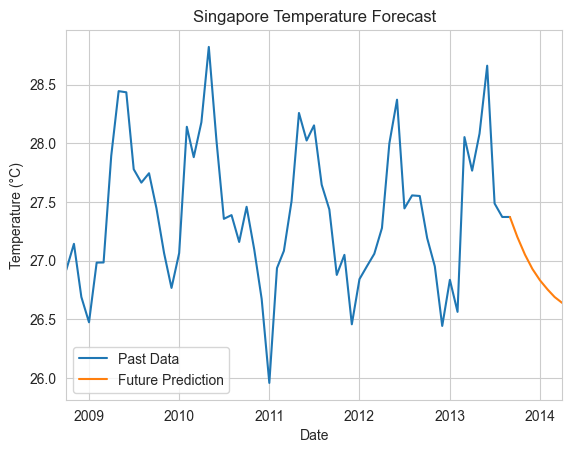

In [24]:
singapore_temps = GlobalLandTemperaturesByCountry[(GlobalLandTemperaturesByCountry['Country'] == 'Singapore') &(GlobalLandTemperaturesByCountry['dt'] >= '1700-01-01')][['dt', 'AverageTemperature']]

# Remove NaN values by interpolation
singapore_temps = singapore_temps.interpolate()

# Convert the date column to datetime
singapore_temps['dt'] = pd.to_datetime(singapore_temps['dt'])

# Get the last date present in the dataset
last_date = singapore_temps['dt'].max()

# Set the date column as the index
singapore_temps.set_index('dt', inplace=True)
singapore_temps.index.freq = 'MS'

# Create a new DataFrame with the next seven days
forecast_dates = pd.date_range(last_date, periods=8, freq='MS')
forecast = pd.DataFrame({'date': forecast_dates})

# Set the date column as the index with frequency 'D'
forecast.set_index('date', inplace=True)
forecast.index.freq = 'MS'

# Select the AR model
model = ARIMA(singapore_temps, order=(1, 0, 1))
results_ARIMA = model.fit(method='innovations_mle')

# Forecast the temperature for the next seven days
forecast['temperature'] = results_ARIMA.forecast(steps=7)
forecast.iloc[0] = singapore_temps.iloc[-1]
print(forecast)

# Plot the last 5 years (60months) of the original data
plt.plot(singapore_temps.index[-60:], singapore_temps['AverageTemperature'][-60:], label='Past Data')

# Plot the forecasted data
plt.plot(forecast.index, forecast['temperature'], label='Future Prediction')

# Add title, labels and legend
plt.title('Singapore Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Set x-limits to show only the last 5 years of data
plt.xlim(singapore_temps.index[-60], forecast.index[-1])

# Show the plot
plt.show()

Reflect on the quality of the prediction.
> your answer : The quality of the prediction made using the ARIMA model with p=1, q=1, and d=0 for the temperature forecast is moderately good. The model was able to predict the temperature relatively accurately for the next seven months, but the monotonic slope of the prediction continues in the spring months which could be a potential limitation (we can safely assume that in spring the temperature should slightly increase, a phenomena which was not sucessfully predicted by the ARIMA model).


#### Additional tutorials and references
1. http://pandas.pydata.org/pandas-docs/stable/10min.html
2. http://www.scipy-lectures.org
3. https://www.youtube.com/playlist?list=PLfZeRfzhgQzTMgwFVezQbnpc1ck0I6CQl
4. https://github.com/ThunderShiviah/samsung_android_time_series_analysis/blob/master/notebooks/time_series_analysis.ipynb
5. Analyzing features for activity recognition, Tam Huynh et al. ˆ
6. https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb
7. https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/ft.ipynb
8. https://github.com/nipunbatra/ProgramaticallyUnderstandingSeries/blob/master/dtw.ipynb
9. http://www.phon.ox.ac.uk/jcoleman/old_SLP/Lecture_5/DTW_explanation.html
10. https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
11. https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
12. https://www.learnpython.org
13. https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb
14. Activity Recognition from Accelerometer Data, Nishkam Ravi et al.